# Overview

Este notebook tem como objetivo realizar todas as etapas de exploração de dados, tratamento e treinamento de um modelo de machine learning. No entanto, devido à falta de tempo (estava em semana de provas e com muita demanda no trabalho), não consegui organizar o notebook de maneira ideal, deixando-o mais estruturado e modularizado.

O plano original era desenvolver um modelo de previsão de séries temporais, investindo mais tempo em feature engineering e na otimização de hiperparâmetros.

Minha intenção futura era:

- Armazenar os arquivos em um bucket no Amazon S3 para simular um banco de dados.
- Treinar o modelo utilizando o Amazon SageMaker.
- Criar um endpoint no SageMaker para servir o modelo.
- Salvar os resultados no Amazon Redshift.
- Conectar o processo a um AWS Lambda para simular novas entradas de dados e automatizar o pipeline.

Como minha expertise está mais focada em Processamento de Linguagem Natural (NLP), este notebook reflete um esforço improvisado, dentro do que consegui desenvolver em 2 dias, utilizando o tempo livre que tive.


# Imports

In [4352]:
# Warnings
import warnings  # To handle warnings, placed at the top for general configuration
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore FutureWarnings

# Data manipulation and utilities
import pandas as pd
import numpy as np
from utils import helper  

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# Machine learning models and processing
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb

# Model evaluation and scoring
from sklearn.metrics import (f1_score, accuracy_score, classification_report, precision_recall_curve, precision_recall_curve, roc_curve,
                             roc_auc_score, confusion_matrix)

# Data preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model selection and hyperparameter tuning
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     TimeSeriesSplit, RandomizedSearchCV)
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Dados

## Base Cadastral

In [4353]:
base_cadastral = pd.read_csv("/Users/mmoraes/Documents/Projects/Datarisk_case/data/base_cadastral.csv")
base_cadastral.shape

(1315, 8)

In [4354]:
base_cadastral.head()

,ID_CLIENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
0,1661240395903230676,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65
1,8274986328479596038,2017-01-25,31,NaN,Comércio,YAHOO,MEDIO,77
2,345447888460137901,2000-08-15,75,NaN,Serviços,HOTMAIL,PEQUENO,48
3,1003144834589372198,2017-08-06,49,NaN,Serviços,OUTLOOK,PEQUENO,89
4,324916756972236008,2011-02-14,88,NaN,Serviços,GMAIL,GRANDE,62


In [4355]:
base_cadastral.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID_CLIENTE           1315 non-null   int64 
 1   DATA_CADASTRO        1315 non-null   object
 2   DDD                  1078 non-null   object
 3   FLAG_PF              66 non-null     object
 4   SEGMENTO_INDUSTRIAL  1232 non-null   object
 5   DOMINIO_EMAIL        1285 non-null   object
 6   PORTE                1274 non-null   object
 7   CEP_2_DIG            1315 non-null   object
dtypes: int64(1), object(7)
memory usage: 82.3+ KB


In [4356]:
duplicated_ids = base_cadastral['ID_CLIENTE'].duplicated().sum()

print(f"Número de ID_CLIENTE duplicados em base_cadastral: {duplicated_ids}")

Número de ID_CLIENTE duplicados em base_cadastral: 0


### FLAG_PF

In [4357]:
base_cadastral['FLAG_PF'].value_counts()

FLAG_PF
X    66
Name: count, dtype: int64

In [4358]:
base_cadastral['FLAG_PF'] = base_cadastral['FLAG_PF'].replace({None: 'PJ'})

base_cadastral['FLAG_PF'].value_counts()

FLAG_PF
PJ    1249
X       66
Name: count, dtype: int64

In [4359]:
base_cadastral = base_cadastral[base_cadastral['FLAG_PF'] != 'X']
base_cadastral['FLAG_PF'].value_counts()

FLAG_PF
PJ    1249
Name: count, dtype: int64

## Base Info

In [4360]:
base_info = pd.read_csv("/Users/mmoraes/Documents/Projects/Datarisk_case/data/base_info.csv")
base_info.shape

(24401, 4)

In [4361]:
base_info.head()

,ID_CLIENTE,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230676,2018-09,16913.0,92.0
1,8274986328479596038,2018-09,106430.0,141.0
2,345447888460137901,2018-09,707439.0,99.0
3,1003144834589372198,2018-09,239659.0,96.0
4,324916756972236008,2018-09,203123.0,103.0


In [4362]:
base_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24401 entries, 0 to 24400
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_CLIENTE          24401 non-null  int64  
 1   SAFRA_REF           24401 non-null  object 
 2   RENDA_MES_ANTERIOR  24401 non-null  float64
 3   NO_FUNCIONARIOS     24401 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 762.7+ KB


## Base Pagamentos - Desenvolvimento

In [4363]:
base_pagamentos_desenvolvimento = pd.read_csv("/Users/mmoraes/Documents/Projects/Datarisk_case/data/base_pagamentos_desenvolvimento.csv")
base_pagamentos_desenvolvimento.shape

(77414, 7)

In [4364]:
base_pagamentos_desenvolvimento['ID_CLIENTE'].nunique()

1248

In [4365]:
base_pagamentos_desenvolvimento.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99


In [4366]:
base_pagamentos_desenvolvimento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77414 entries, 0 to 77413
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID_CLIENTE              77414 non-null  int64  
 1   SAFRA_REF               77414 non-null  object 
 2   DATA_EMISSAO_DOCUMENTO  77414 non-null  object 
 3   DATA_PAGAMENTO          77414 non-null  object 
 4   DATA_VENCIMENTO         77414 non-null  object 
 5   VALOR_A_PAGAR           77414 non-null  float64
 6   TAXA                    77414 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 4.1+ MB


## Base Pagamentos - Teste

In [4367]:
base_pagamentos_teste = pd.read_csv("/Users/mmoraes/Documents/Projects/Datarisk_case/data/base_pagamentos_teste.csv")
base_pagamentos_teste.shape

(12275, 6)

In [4368]:
base_pagamentos_teste.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99
3,274692171162531764,2021-07,2021-07-16,2021-08-30,62250.00,5.99
4,465309249432033993,2021-07,2021-07-05,2021-07-30,26593.95,6.99


In [4369]:
#Essa verificacao vai servir para posteriormente usar o mesmo para prever a inadimplencia nos dados históricos de clientes.

clientes_unicos_teste = base_pagamentos_teste['ID_CLIENTE'].unique()
clientes_unicos_desenvolvimento = base_pagamentos_desenvolvimento['ID_CLIENTE'].unique()

# Converte para conjuntos para facilitar a comparação
clientes_unicos_teste_set = set(clientes_unicos_teste)
clientes_unicos_desenvolvimento_set = set(clientes_unicos_desenvolvimento)

# Encontra os clientes comuns entre as duas bases
clientes_comuns = clientes_unicos_teste_set.intersection(clientes_unicos_desenvolvimento_set)
len(clientes_comuns)

888

In [4370]:
len(clientes_unicos_teste)

976

## Merge - Base Info e Base Pagamentos

Usando as Primary Key ID_CLIENTE e SAFRA_REF

In [4371]:
merged_pagamentos_info = pd.merge(base_pagamentos_desenvolvimento, base_info, on=["ID_CLIENTE", "SAFRA_REF"], how="left")
merged_pagamentos_info.shape


(77414, 9)

In [4372]:
merged_pagamentos_info.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,NaN,NaN
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,NaN,NaN
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,NaN,NaN
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,NaN,NaN
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,NaN,NaN


# Merge 

In [4373]:
merged_final = pd.merge(merged_pagamentos_info, base_cadastral, on="ID_CLIENTE", how="left")
merged_final.shape

(77414, 16)

In [4374]:
duplicated_rows = merged_final.duplicated()
num_duplicated_rows = duplicated_rows.sum()

print(f"Número de linhas duplicadas em base_pagamentos_desenvolvimento: {num_duplicated_rows}")

Número de linhas duplicadas em base_pagamentos_desenvolvimento: 0


In [4375]:
merged_final.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,NaN,NaN,2013-08-22,99,PJ,Serviços,YAHOO,PEQUENO,65
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,NaN,NaN,2013-08-22,99,PJ,Serviços,YAHOO,PEQUENO,65
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,NaN,NaN,2013-08-22,99,PJ,Serviços,YAHOO,PEQUENO,65
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,NaN,NaN,2013-08-22,99,PJ,Serviços,YAHOO,PEQUENO,65
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,NaN,NaN,2013-08-22,99,PJ,Serviços,YAHOO,PEQUENO,65


In [4376]:
merged_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77414 entries, 0 to 77413
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID_CLIENTE              77414 non-null  int64  
 1   SAFRA_REF               77414 non-null  object 
 2   DATA_EMISSAO_DOCUMENTO  77414 non-null  object 
 3   DATA_PAGAMENTO          77414 non-null  object 
 4   DATA_VENCIMENTO         77414 non-null  object 
 5   VALOR_A_PAGAR           77414 non-null  float64
 6   TAXA                    77414 non-null  float64
 7   RENDA_MES_ANTERIOR      73477 non-null  float64
 8   NO_FUNCIONARIOS         73477 non-null  float64
 9   DATA_CADASTRO           77195 non-null  object 
 10  DDD                     69862 non-null  object 
 11  FLAG_PF                 77195 non-null  object 
 12  SEGMENTO_INDUSTRIAL     75997 non-null  object 
 13  DOMINIO_EMAIL           76308 non-null  object 
 14  PORTE                   74720 non-null

# Tratamento

In [4377]:
missing_values_merged = helper.check_missing_values(merged_final)
missing_values_merged

RENDA_MES_ANTERIOR     3937
NO_FUNCIONARIOS        3937
DATA_CADASTRO           219
DDD                    7552
FLAG_PF                 219
SEGMENTO_INDUSTRIAL    1417
DOMINIO_EMAIL          1106
PORTE                  2694
CEP_2_DIG               219
dtype: int64

In [4378]:
def preencher_numericos(grupo):
    """ Preencher valores nulos com o último valor conhecido"""
    grupo['NO_FUNCIONARIOS'] = grupo['NO_FUNCIONARIOS'].fillna(method='ffill')
    grupo['RENDA_MES_ANTERIOR'] = grupo['RENDA_MES_ANTERIOR'].fillna(method='ffill')
    
    # Preencher valores nulos restantes com o próximo valor conhecido
    grupo['NO_FUNCIONARIOS'] = grupo['NO_FUNCIONARIOS'].fillna(method='bfill')
    grupo['RENDA_MES_ANTERIOR'] = grupo['RENDA_MES_ANTERIOR'].fillna(method='bfill')
    
    # Se ainda houver valores nulos, preencher com a média geral do cliente
    grupo['NO_FUNCIONARIOS'] = grupo['NO_FUNCIONARIOS'].fillna(grupo['NO_FUNCIONARIOS'].mean())
    grupo['RENDA_MES_ANTERIOR'] = grupo['RENDA_MES_ANTERIOR'].fillna(grupo['RENDA_MES_ANTERIOR'].mean())
    
    return grupo

merged_final = merged_final.groupby('ID_CLIENTE', group_keys=False).apply(preencher_numericos)

/var/folders/2j/4bp3mpqn673cqywvjyhff8_w0000gq/T/ipykernel_10242/871509861.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_final = merged_final.groupby('ID_CLIENTE', group_keys=False).apply(preencher_numericos)


In [4379]:
missing_values_merged = helper.check_missing_values(merged_final)
missing_values_merged

RENDA_MES_ANTERIOR       93
NO_FUNCIONARIOS          93
DATA_CADASTRO           219
DDD                    7552
FLAG_PF                 219
SEGMENTO_INDUSTRIAL    1417
DOMINIO_EMAIL          1106
PORTE                  2694
CEP_2_DIG               219
dtype: int64

In [4380]:
merged_final = merged_final.dropna(subset=['RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'PORTE', 'SEGMENTO_INDUSTRIAL'])

In [4381]:
missing_values_merged = helper.check_missing_values(merged_final)
missing_values_merged

DDD              6086
DOMINIO_EMAIL     880
dtype: int64

In [4382]:
merged_final['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(merged_final['DATA_EMISSAO_DOCUMENTO'])
merged_final['DATA_PAGAMENTO'] = pd.to_datetime(merged_final['DATA_PAGAMENTO'])
merged_final['DATA_VENCIMENTO'] = pd.to_datetime(merged_final['DATA_VENCIMENTO'])
merged_final['DATA_CADASTRO'] = pd.to_datetime(merged_final['DATA_CADASTRO'])

# Feature Engineering

In [4383]:
#Target
merged_final.loc[:, 'DATA_PAGAMENTO'] = pd.to_datetime(merged_final['DATA_PAGAMENTO'], errors='coerce')
merged_final.loc[:, 'DATA_VENCIMENTO'] = pd.to_datetime(merged_final['DATA_VENCIMENTO'], errors='coerce')

merged_final.loc[:, 'INADIMPLENTE'] = (merged_final['DATA_PAGAMENTO'] - merged_final['DATA_VENCIMENTO']).dt.days >= 5

merged_final.loc[:, 'INADIMPLENTE'] = merged_final['INADIMPLENTE'].astype(int)

In [4384]:
#Feature: Tempo de cadastro até a data atual
merged_final['TEMPO_RELACIONAMENTO_MESES'] = ((merged_final['DATA_EMISSAO_DOCUMENTO'] - merged_final['DATA_CADASTRO']).dt.days) / 30

In [4385]:
merged_final['DIAS_ATRASO_PAGAMENTO'] = (merged_final['DATA_PAGAMENTO'] - merged_final['DATA_VENCIMENTO']).dt.days
merged_final['DIAS_ATRASO_PAGAMENTO'] = merged_final['DIAS_ATRASO_PAGAMENTO'].apply(lambda x: max(x, 0))

# Ordenar o DataFrame
merged_final.sort_values(['ID_CLIENTE', 'DATA_EMISSAO_DOCUMENTO'], inplace=True)

# Calcular a soma cumulativa dos dias de atraso por cliente
merged_final['CUM_SUM_ATRASO'] = merged_final.groupby('ID_CLIENTE')['DIAS_ATRASO_PAGAMENTO'].cumsum()

# Calcular a soma cumulativa dos quadrados dos dias de atraso por cliente
merged_final['CUM_SUM_ATRASO_QUADRADO'] = merged_final.groupby('ID_CLIENTE')['DIAS_ATRASO_PAGAMENTO'].transform(lambda x: (x**2).cumsum())

# Calcular a contagem cumulativa de transações por cliente
merged_final['CUM_COUNT'] = merged_final.groupby('ID_CLIENTE').cumcount() + 1  # Adicionamos 1 para evitar divisão por zero

# Calcular média cumulativa
merged_final['MEDIA_CUM_DIAS_ATRASO'] = merged_final['CUM_SUM_ATRASO'] / merged_final['CUM_COUNT']

# Calcular variância cumulativa
merged_final['VARIANCIA_CUM_DIAS_ATRASO'] = (
    (merged_final['CUM_SUM_ATRASO_QUADRADO'] / merged_final['CUM_COUNT']) - 
    (merged_final['MEDIA_CUM_DIAS_ATRASO'] ** 2)
).clip(lower=0)  # Garantir que a variância não seja negativa

In [4386]:
#Feature: Taxa de utilizacao do credito (TAXA_UTILIZACAO = VALOR_A_PAGAR / RENDA_MES_ANTERIOR)

merged_final['TAXA_UTILIZACAO'] = merged_final.apply(
    lambda x: x['VALOR_A_PAGAR'] / x['RENDA_MES_ANTERIOR']
    if pd.notnull(x['RENDA_MES_ANTERIOR']) and x['RENDA_MES_ANTERIOR'] != 0 else np.nan,
    axis=1
)

In [4387]:
#Feature: Número de vezes que o cliente esteve inadimplente
## Leva em consideracao o histórico do cliente

merged_final.sort_values(['ID_CLIENTE', 'DATA_EMISSAO_DOCUMENTO'], inplace=True)

# Calcular o somatório cumulativo de inadimplências por cliente
merged_final['NUMERO_INADIMPLENCIAS'] = merged_final.groupby('ID_CLIENTE')['INADIMPLENTE'].cumsum()

# Deslocar o somatório cumulativo em uma posição para excluir a inadimplência da transação atual
merged_final['NUMERO_INADIMPLENCIAS'] = merged_final.groupby('ID_CLIENTE')['NUMERO_INADIMPLENCIAS'].shift(1)

# Preencher valores NaN resultantes do shift com zero (primeira transação do cliente)
merged_final['NUMERO_INADIMPLENCIAS'] = merged_final['NUMERO_INADIMPLENCIAS'].fillna(0)

In [4388]:
def calcular_taxa_inadimplencia_historica(df):
    df = df.sort_values(['DATA_EMISSAO_DOCUMENTO'])
    df['TAXA_INADIMPLENCIA_SEGMENTO'] = df.groupby('SEGMENTO_INDUSTRIAL').apply(
        lambda x: x['INADIMPLENTE'].expanding().mean()
    ).reset_index(level=0, drop=True)
    return df

merged_final = calcular_taxa_inadimplencia_historica(merged_final)

/var/folders/2j/4bp3mpqn673cqywvjyhff8_w0000gq/T/ipykernel_10242/4294700297.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['TAXA_INADIMPLENCIA_SEGMENTO'] = df.groupby('SEGMENTO_INDUSTRIAL').apply(


In [4389]:
merged_final

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DATA_CADASTRO,...,TEMPO_RELACIONAMENTO_MESES,DIAS_ATRASO_PAGAMENTO,CUM_SUM_ATRASO,CUM_SUM_ATRASO_QUADRADO,CUM_COUNT,MEDIA_CUM_DIAS_ATRASO,VARIANCIA_CUM_DIAS_ATRASO,TAXA_UTILIZACAO,NUMERO_INADIMPLENCIAS,TAXA_INADIMPLENCIA_SEGMENTO
166,8784237149961904,2018-08,2018-08-17,2018-09-04,2018-09-04,100616.10,5.99,300502.0,107.0,2011-02-14,...,91.366667,0,0,0,1,0.000000,0.00000,0.334827,0.0,0.000000
200,4334472256949955221,2018-08,2018-08-17,2018-09-03,2018-09-03,38391.54,5.99,354607.0,109.0,2012-03-11,...,78.333333,0,0,0,1,0.000000,0.00000,0.108265,0.0,0.000000
113,4095739077267179172,2018-08,2018-08-17,2018-09-03,2018-09-03,91187.75,6.99,292798.0,122.0,2011-02-14,...,91.366667,0,0,0,1,0.000000,0.00000,0.311436,0.0,0.000000
87,4052557282157719526,2018-08,2018-08-17,2018-09-03,2018-09-03,29891.85,4.99,286491.0,112.0,2009-08-30,...,109.133333,0,0,0,1,0.000000,0.00000,0.104338,0.0,0.000000
49,3668905663669864663,2018-08,2018-08-17,2018-09-03,2018-09-03,21476.35,8.99,331138.0,137.0,2011-02-14,...,91.366667,0,0,0,1,0.000000,0.00000,0.064856,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76446,1115703227712697214,2021-06,2021-06-30,2021-07-30,2021-07-30,100851.89,5.99,318262.0,95.0,2011-02-14,...,126.300000,0,1368,331772,130,10.523077,2441.35716,0.316883,9.0,0.044715
77410,5220206408301580591,2021-06,2021-06-30,2021-08-16,2021-08-16,42239.00,5.99,235315.0,87.0,2021-04-08,...,2.766667,0,0,0,2,0.000000,0.00000,0.179500,0.0,0.069445
77396,5200455618694210402,2021-06,2021-06-30,2021-07-19,2021-07-19,197916.84,6.99,366474.0,94.0,2015-05-10,...,74.766667,0,0,0,12,0.000000,0.00000,0.540057,0.0,0.044713
76176,274692171162531764,2021-06,2021-06-30,2021-08-16,2021-08-16,40479.00,5.99,396932.0,110.0,2005-08-03,...,193.666667,0,292,21530,230,1.269565,91.99690,0.101980,6.0,0.082640


# EDA

Como o mesmo cliente tem diversas transacoes e pode variar os níComo cada cliente pode ter diversas transações e apresentar variações nos níveis de inadimplência ao longo do tempo, agrupei os clientes de acordo com a proporção de inadimplência em suas transações.

Por exemplo: clientes com 0% de inadimplência nunca atrasaram pagamentos, enquanto aqueles com 1-10% de inadimplência foram inadimplentes em até 10% de suas transações, considerando o mesmo ID_CLIENTE.veis de inadimplencia, criei grupos de inadimplencia pela proporcao de inadimplencia por cliente.

POr exemplo: 0% são os clientes que nunca foram inadimplentes, 1-10% são os clientes que foram até 10% inadimplentes, com referencia as transacoes do mesmo ID_CLIENTE

Número de clientes por grupo de inadimplência:
Grupo_Inadimplencia
0%         550
1-20%      366
21-40%      79
41-60%      36
61-80%      16
81-100%     31
Name: count, dtype: int64


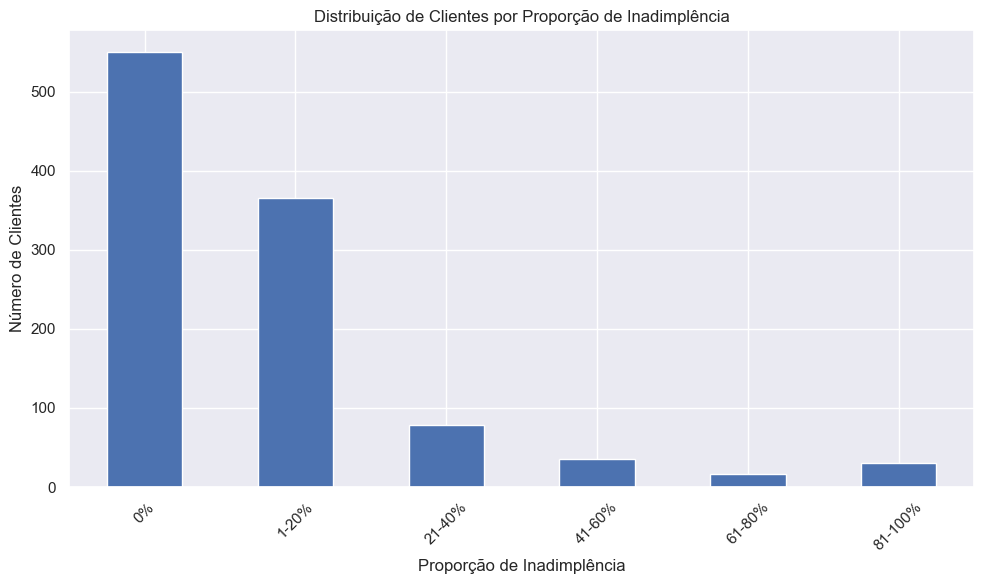

In [4390]:
total_operacoes = merged_final.groupby('ID_CLIENTE').size()
total_inadimplencias = merged_final.groupby('ID_CLIENTE')['INADIMPLENTE'].sum()

proporcao_inadimplencia = (total_inadimplencias / total_operacoes).reset_index()
proporcao_inadimplencia.columns = ['ID_CLIENTE', 'Proporcao_Inadimplencia']

bins = [-0.01, 0, 0.2, 0.4, 0.6, 0.8, 1]  
labels = [
    '0%', '1-20%', '21-40%', '41-60%', '61-80%', '81-100%'
]

proporcao_inadimplencia['Grupo_Inadimplencia'] = pd.cut(
    proporcao_inadimplencia['Proporcao_Inadimplencia'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

contagem_por_grupo = proporcao_inadimplencia['Grupo_Inadimplencia'].value_counts().sort_index()

print("Número de clientes por grupo de inadimplência:")
print(contagem_por_grupo)

plt.figure(figsize=(10, 6))
contagem_por_grupo.plot(kind='bar')
plt.title('Distribuição de Clientes por Proporção de Inadimplência')
plt.xlabel('Proporção de Inadimplência')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

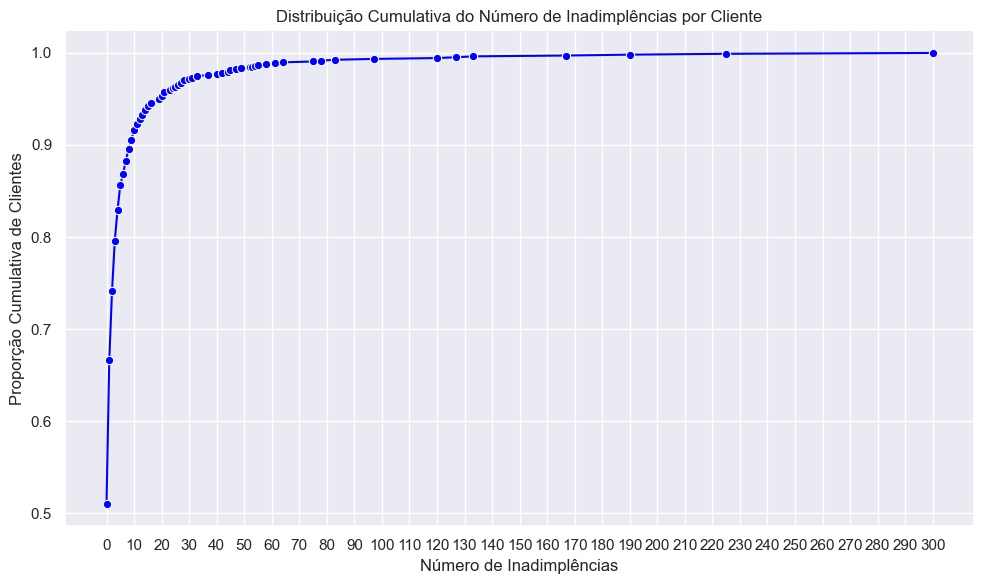

In [4391]:
#Plot para visualizar a inadimplencia acumulativa.

inadimplencia_por_cliente = merged_final.groupby('ID_CLIENTE')['INADIMPLENTE'].sum().reset_index()

# Contando quantas vezes cada cliente foi inadimplente
contagem_inadimplencia = inadimplencia_por_cliente['INADIMPLENTE'].value_counts().reset_index()
contagem_inadimplencia.columns = ['Numero_de_inadimplencias', 'Quantidade_de_clientes']

# Ordenando pela quantidade de inadimplências
contagem_inadimplencia = contagem_inadimplencia.sort_values(by='Numero_de_inadimplencias')

contagem_inadimplencia['Distribuicao_Cumulativa'] = contagem_inadimplencia['Quantidade_de_clientes'].cumsum() / contagem_inadimplencia['Quantidade_de_clientes'].sum()


plt.figure(figsize=(10, 6))
sns.lineplot(x='Numero_de_inadimplencias', y='Distribuicao_Cumulativa', data=contagem_inadimplencia, marker="o", color='blue')
plt.title('Distribuição Cumulativa do Número de Inadimplências por Cliente')
plt.xlabel('Número de Inadimplências')
plt.ylabel('Proporção Cumulativa de Clientes')
max_inadimplencias = contagem_inadimplencia['Numero_de_inadimplencias'].max()
plt.xticks(np.arange(0, max_inadimplencias + 1, 10))
plt.tight_layout()
plt.show()

Como podemos observar, aproximadamente 90% dos clientes cometeram até 10 inadimplências, enquanto os outros 10% se distribuem entre 10 e 300 inadimplências. Nota-se que, conforme a quantidade de inadimplências aumenta, a frequência de clientes nessa faixa diminui rapidamente.

In [4392]:
def preparar_dados_inadimplencia(df):
    total_operacoes = df.groupby('ID_CLIENTE').size()
    total_inadimplencias = df.groupby('ID_CLIENTE')['INADIMPLENTE'].sum()
    proporcao_inadimplencia = (total_inadimplencias / total_operacoes).reset_index()
    proporcao_inadimplencia.columns = ['ID_CLIENTE', 'Proporcao_Inadimplencia']
    proporcao_inadimplencia['Grupo_Inadimplencia'] = pd.cut(
        proporcao_inadimplencia['Proporcao_Inadimplencia'], 
        bins=bins, 
        labels=labels, 
        include_lowest=True
    )
    
    return pd.merge(
        proporcao_inadimplencia, 
        df[['ID_CLIENTE', 'TEMPO_RELACIONAMENTO_MESES', 'NO_FUNCIONARIOS', 'RENDA_MES_ANTERIOR', 
            'PORTE', 'SEGMENTO_INDUSTRIAL', 'VALOR_A_PAGAR', 'TAXA_UTILIZACAO']].drop_duplicates(), 
        on='ID_CLIENTE'
    )

# Função para calcular estatísticas (média, mediana, contagem) por grupo de inadimplência
def calcular_estatisticas_por_grupo(df, coluna):
    return df.groupby('Grupo_Inadimplencia')[coluna].agg(['mean', 'median', 'count']).reset_index()

# Função para calcular a média por cliente
def calcular_media_por_cliente(df, coluna):
    return df.groupby('ID_CLIENTE')[coluna].mean().reset_index()

# Função genérica para calcular médias por cliente, associar com grupo e calcular estatísticas
def calcular_estatisticas_por_cliente(df, coluna):
    media_por_cliente = calcular_media_por_cliente(df, coluna)
    media_agrupada = pd.merge(proporcao_inadimplencia[['ID_CLIENTE', 'Grupo_Inadimplencia']], media_por_cliente, on='ID_CLIENTE')
    return calcular_estatisticas_por_grupo(media_agrupada, coluna)

# Preparar dados com proporção de inadimplência
dados_completos = preparar_dados_inadimplencia(merged_final)

# Calcular e imprimir estatísticas para diferentes variáveis
variaveis = ['TEMPO_RELACIONAMENTO_MESES', 'NO_FUNCIONARIOS', 'RENDA_MES_ANTERIOR']
estatisticas = {var: calcular_estatisticas_por_grupo(dados_completos, var) for var in variaveis}

for var, stats in estatisticas.items():
    print(f"\nEstatísticas para {var}:")
    print(stats)

# Calcular a TAXA_UTILIZACAO para cada transação
dados_completos['TAXA_UTILIZACAO'] = dados_completos.apply(
    lambda x: x['VALOR_A_PAGAR'] / x['RENDA_MES_ANTERIOR'] if pd.notnull(x['RENDA_MES_ANTERIOR']) and x['RENDA_MES_ANTERIOR'] != 0 else np.nan,
    axis=1
)

estatisticas_renda = calcular_estatisticas_por_cliente(dados_completos, 'RENDA_MES_ANTERIOR')
estatisticas_valor_pagar = calcular_estatisticas_por_cliente(dados_completos, 'VALOR_A_PAGAR')
estatisticas_taxa_utilizacao = calcular_estatisticas_por_cliente(dados_completos, 'TAXA_UTILIZACAO')

print("\nEstatísticas para RENDA_MES_ANTERIOR:")
print(estatisticas_renda)
print("\nEstatísticas para VALOR_A_PAGAR:")
print(estatisticas_valor_pagar)
print("\nEstatísticas para TAXA_UTILIZACAO:")
print(estatisticas_taxa_utilizacao)


Estatísticas para TEMPO_RELACIONAMENTO_MESES:
  Grupo_Inadimplencia        mean      median  count
0                  0%  118.150888  101.633333  25617
1               1-20%  121.774625  106.966667  39214
2              21-40%  135.478297  120.466667   5735
3              41-60%   82.707611   67.633333   1581
4              61-80%   66.002277   69.533333    893
5             81-100%   80.608052   37.600000    207

Estatísticas para NO_FUNCIONARIOS:
  Grupo_Inadimplencia        mean  median  count
0                  0%  118.172893   118.0  25617
1               1-20%  117.055414   117.0  39214
2              21-40%  120.329381   122.0   5735
3              41-60%  107.979127   102.0   1581
4              61-80%  122.637178   119.0    893
5             81-100%  123.845411   120.0    207

Estatísticas para RENDA_MES_ANTERIOR:
  Grupo_Inadimplencia           mean    median  count
0                  0%  300656.288636  253903.0  25617
1               1-20%  295536.147294  245366.0  39214
2 

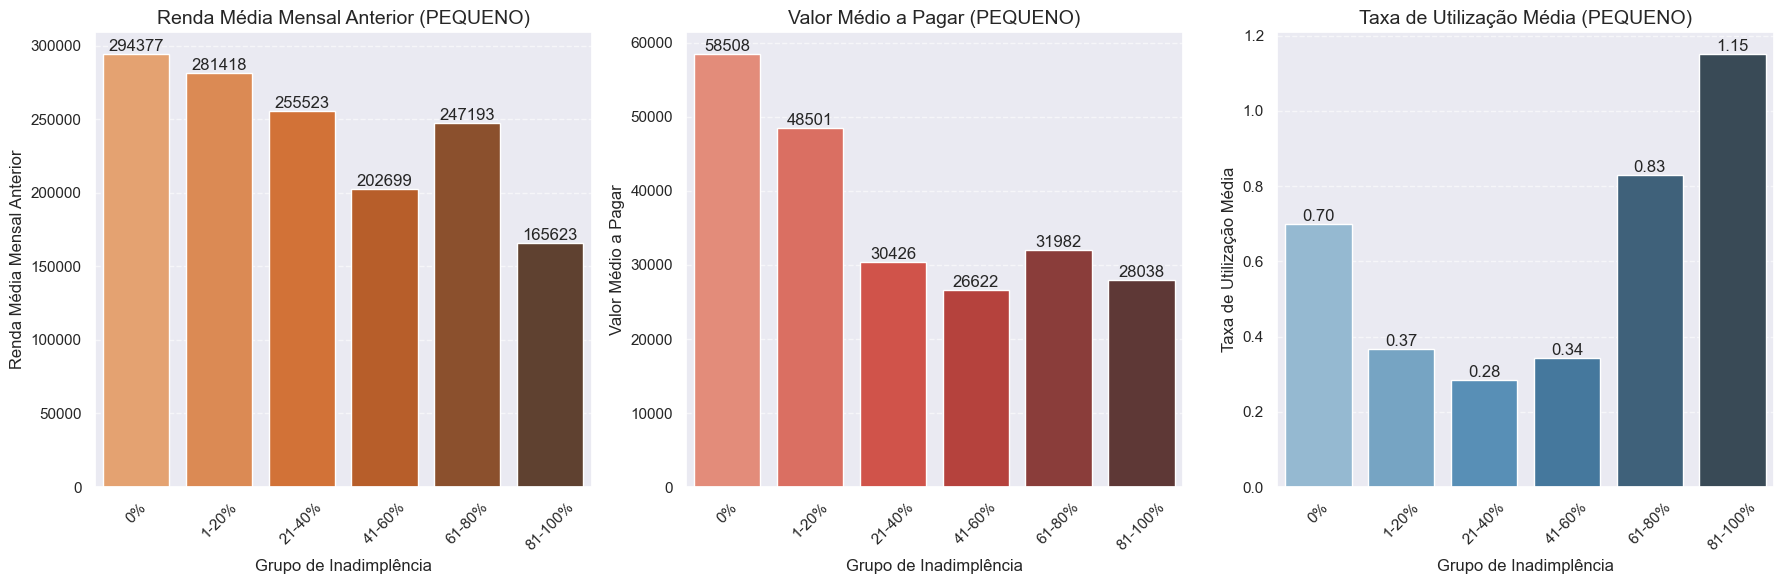

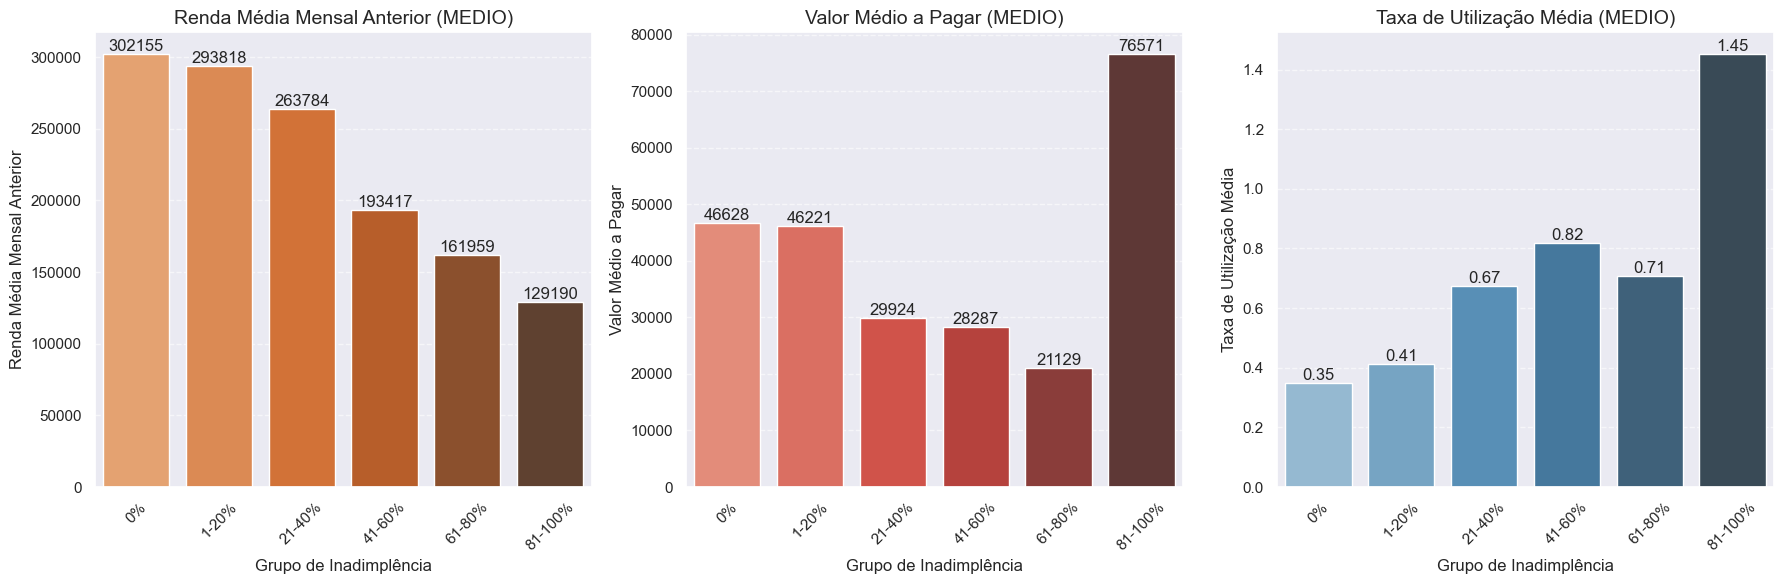

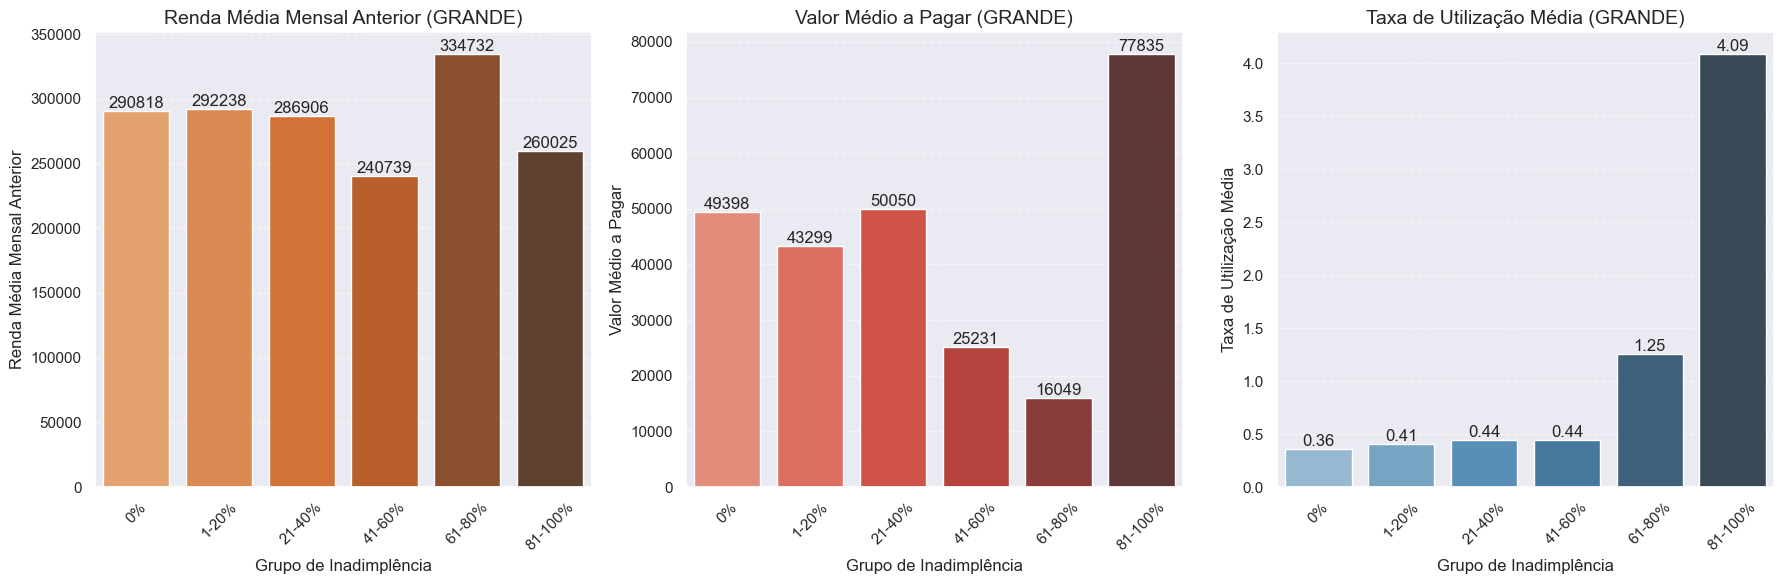

In [4393]:
def gerar_graficos_por_porte(df, porte_label, palette_orange, palette_red, palette_blue):

    #Etatísticas por grupo de inadimplência
    estatisticas_renda = calcular_estatisticas_por_cliente(df, 'RENDA_MES_ANTERIOR')
    estatisticas_valor_pagar = calcular_estatisticas_por_cliente(df, 'VALOR_A_PAGAR')
    estatisticas_taxa_utilizacao = calcular_estatisticas_por_cliente(df, 'TAXA_UTILIZACAO')

    # Plotar gráficos
    plt.figure(figsize=(18, 6))
    
    # Gráfico 1: Renda Média Mensal Anterior por Grupo de Inadimplência
    plt.subplot(1, 3, 1)
    sns.barplot(x='Grupo_Inadimplencia', y='mean', data=estatisticas_renda, palette=palette_orange)
    plt.title(f'Renda Média Mensal Anterior ({porte_label})', fontsize=14)
    plt.xlabel('Grupo de Inadimplência', fontsize=12)
    plt.ylabel('Renda Média Mensal Anterior', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    for i, v in enumerate(estatisticas_renda['mean']):
        plt.text(i, v, f'{v:.0f}', ha='center', va='bottom')

    # Gráfico 2: Valor Médio a Pagar por Grupo de Inadimplência
    plt.subplot(1, 3, 2)
    sns.barplot(x='Grupo_Inadimplencia', y='mean', data=estatisticas_valor_pagar, palette=palette_red)
    plt.title(f'Valor Médio a Pagar ({porte_label})', fontsize=14)
    plt.xlabel('Grupo de Inadimplência', fontsize=12)
    plt.ylabel('Valor Médio a Pagar', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    for i, v in enumerate(estatisticas_valor_pagar['mean']):
        plt.text(i, v, f'{v:.0f}', ha='center', va='bottom')

    # Gráfico 3: Taxa de Utilização Média por Grupo de Inadimplência
    plt.subplot(1, 3, 3)
    sns.barplot(x='Grupo_Inadimplencia', y='mean', data=estatisticas_taxa_utilizacao, palette=palette_blue)
    plt.title(f'Taxa de Utilização Média ({porte_label})', fontsize=14)
    plt.xlabel('Grupo de Inadimplência', fontsize=12)
    plt.ylabel('Taxa de Utilização Média', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    for i, v in enumerate(estatisticas_taxa_utilizacao['mean']):
        plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

palette_orange = sns.color_palette("Oranges_d", n_colors=6)
palette_red = sns.color_palette("Reds_d", n_colors=6)
palette_blue = sns.color_palette("Blues_d", n_colors=6)


# Segmentação por PORTE
for porte in ['PEQUENO', 'MEDIO', 'GRANDE']:
    df_porte = dados_completos[dados_completos['PORTE'] == porte]
    gerar_graficos_por_porte(df_porte, porte, palette_orange, palette_red, palette_blue)

In [4394]:
#Esse cálculo dá o mesmo peso para cada observação (transação ou registro) no grupo "81-100%", independentemente de quantas transações um cliente tem. Ou seja, se um cliente tiver muitas transações, ele influencia mais a média.

(dados_completos['RENDA_MES_ANTERIOR'][dados_completos['Grupo_Inadimplencia'] == '81-100%']).mean()

np.float64(290469.61352657)

In [4395]:
# Esse método pode ser mais representativo se os clientes tiverem rendas significativamente diferentes, pois trata cada cliente de forma independente antes de calcular a média geral.

grupo_81_100 = dados_completos[dados_completos['Grupo_Inadimplencia'] == '81-100%']
mean_renda_by_cliente = grupo_81_100.groupby('ID_CLIENTE')['RENDA_MES_ANTERIOR'].mean()
media_renda_media_por_cliente = mean_renda_by_cliente.mean()
media_renda_media_por_cliente

np.float64(173531.13630799585)

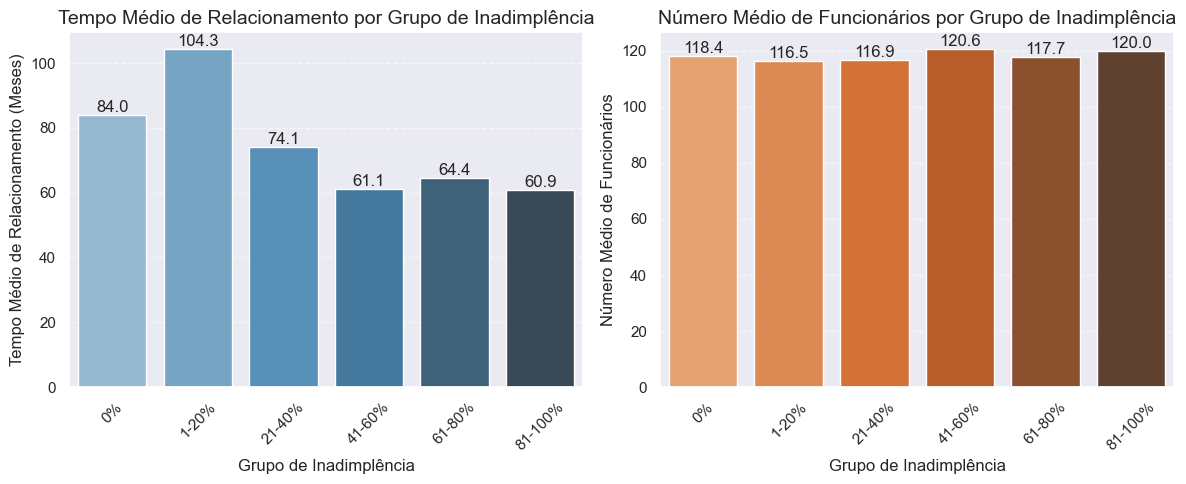

In [4396]:
def calcular_media_por_cliente(df, coluna):
    return df.groupby('ID_CLIENTE')[coluna].mean().reset_index()

# Função para calcular estatísticas por grupo de inadimplência
def calcular_estatisticas_por_grupo(df, coluna):
    return df.groupby('Grupo_Inadimplencia')[coluna].agg(['mean', 'median', 'count']).reset_index()

# Calcular o tempo médio de relacionamento por cliente
tempo_relacionamento_medio_por_cliente = calcular_media_por_cliente(dados_completos, 'TEMPO_RELACIONAMENTO_MESES')

tempo_relacionamento_medio_agrupado = pd.merge(
    proporcao_inadimplencia[['ID_CLIENTE', 'Grupo_Inadimplencia']], 
    tempo_relacionamento_medio_por_cliente, 
    on='ID_CLIENTE'
)

estatisticas_tempo_relacionamento = calcular_estatisticas_por_grupo(tempo_relacionamento_medio_agrupado, 'TEMPO_RELACIONAMENTO_MESES')

no_funcionarios_medio_por_cliente = calcular_media_por_cliente(dados_completos, 'NO_FUNCIONARIOS')

no_funcionarios_medio_agrupado = pd.merge(
    proporcao_inadimplencia[['ID_CLIENTE', 'Grupo_Inadimplencia']], 
    no_funcionarios_medio_por_cliente, 
    on='ID_CLIENTE'
)

estatisticas_no_funcionarios = calcular_estatisticas_por_grupo(no_funcionarios_medio_agrupado, 'NO_FUNCIONARIOS')

plt.figure(figsize=(12, 5))

# Gráfico 1: Tempo Médio de Relacionamento por Grupo de Inadimplência
plt.subplot(1, 2, 1)
barplot1 = sns.barplot(x='Grupo_Inadimplencia', y='mean', data=estatisticas_tempo_relacionamento, palette="Blues_d")
plt.title('Tempo Médio de Relacionamento por Grupo de Inadimplência', fontsize=14)
plt.xlabel('Grupo de Inadimplência', fontsize=12)
plt.ylabel('Tempo Médio de Relacionamento (Meses)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i in barplot1.containers:
    barplot1.bar_label(i, fmt='%.1f')

# Gráfico 2: Número Médio de Funcionários por Grupo de Inadimplência
plt.subplot(1, 2, 2)
barplot2 = sns.barplot(x='Grupo_Inadimplencia', y='mean', data=estatisticas_no_funcionarios, palette="Oranges_d")
plt.title('Número Médio de Funcionários por Grupo de Inadimplência', fontsize=14)
plt.xlabel('Grupo de Inadimplência', fontsize=12)
plt.ylabel('Número Médio de Funcionários', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i in barplot2.containers:
    barplot2.bar_label(i, fmt='%.1f')

# Ajustar o layout
plt.tight_layout()
plt.show()


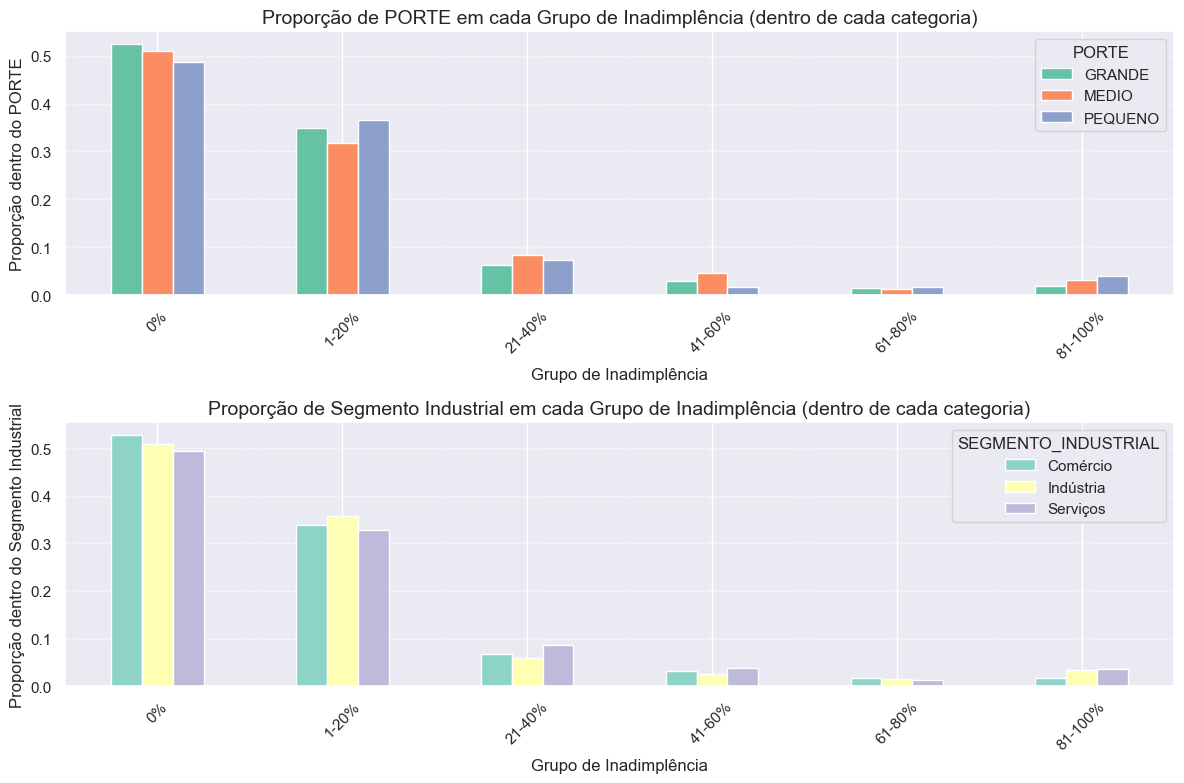

In [4397]:
clientes_unicos = dados_completos[['ID_CLIENTE', 'Grupo_Inadimplencia', 'PORTE', 'SEGMENTO_INDUSTRIAL']].drop_duplicates()

distribuicao_porte = clientes_unicos.groupby(['Grupo_Inadimplencia', 'PORTE']).size().unstack().fillna(0)

distribuicao_segmento = clientes_unicos.groupby(['Grupo_Inadimplencia', 'SEGMENTO_INDUSTRIAL']).size().unstack().fillna(0)

proporcao_porte = distribuicao_porte.div(distribuicao_porte.sum(axis=0), axis=1)
proporcao_segmento = distribuicao_segmento.div(distribuicao_segmento.sum(axis=0), axis=1)


plt.figure(figsize=(12, 8))

# Gráfico 1: Proporção de PORTE em cada Grupo de Inadimplência
plt.subplot(2, 1, 1)
proporcao_porte.plot(kind='bar', stacked=False, ax=plt.gca(), color=sns.color_palette("Set2"))
plt.title('Proporção de PORTE em cada Grupo de Inadimplência (dentro de cada categoria)', fontsize=14)
plt.xlabel('Grupo de Inadimplência', fontsize=12)
plt.ylabel('Proporção dentro do PORTE', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Gráfico 2: Proporção de SEGMENTO_INDUSTRIAL em cada Grupo de Inadimplência
plt.subplot(2, 1, 2)
proporcao_segmento.plot(kind='bar', stacked=False, ax=plt.gca(), color=sns.color_palette("Set3"))
plt.title('Proporção de Segmento Industrial em cada Grupo de Inadimplência (dentro de cada categoria)', fontsize=14)
plt.xlabel('Grupo de Inadimplência', fontsize=12)
plt.ylabel('Proporção dentro do Segmento Industrial', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


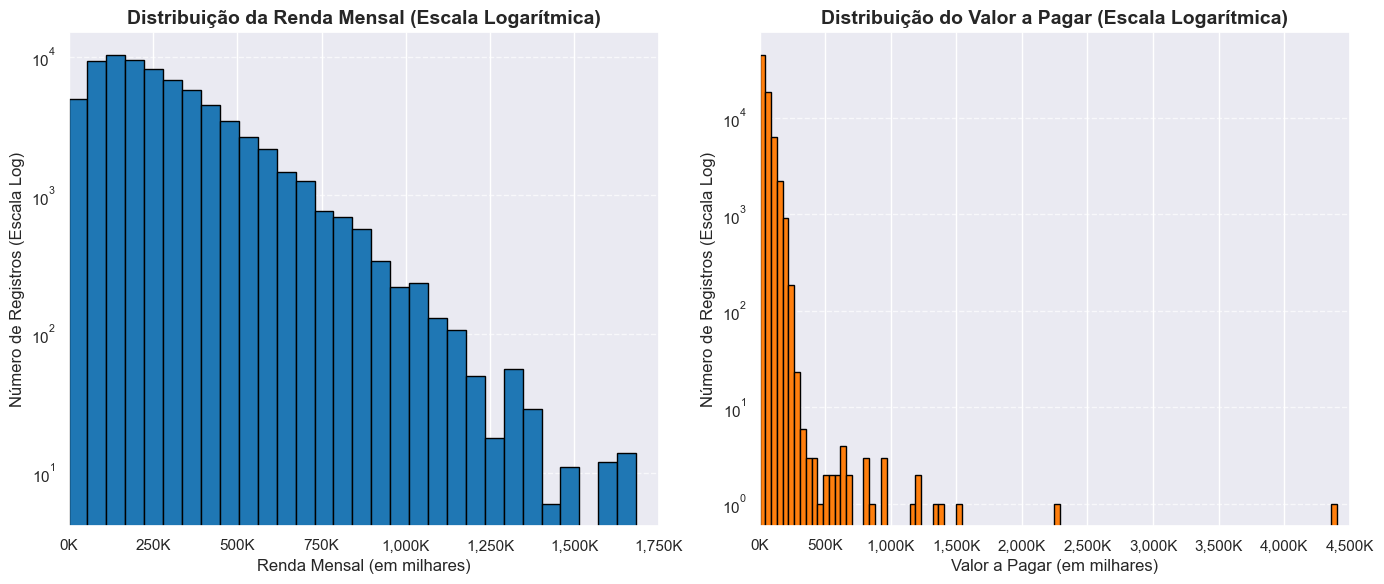

In [4398]:
plt.figure(figsize=(14, 6))

# Histograma de RENDA_MES_ANTERIOR com log
plt.subplot(1, 2, 1)
plt.hist(merged_final['RENDA_MES_ANTERIOR'], bins=30, color='#1f77b4', edgecolor='black', log=True)
plt.title('Distribuição da Renda Mensal (Escala Logarítmica)', fontsize=14, weight='bold')
plt.xlabel('Renda Mensal (em milhares)', fontsize=12)
plt.ylabel('Número de Registros (Escala Log)', fontsize=12)
plt.xlim(0, 1e6)
plt.xticks(np.arange(0, 2000000, 250000))  # Ticks de 0 a 200K com intervalo de 250K
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x/1e3):,}K'))

plt.subplot(1, 2, 2)
plt.hist(merged_final['VALOR_A_PAGAR'], bins=100, color='#ff7f0e', edgecolor='black', log=True)
plt.title('Distribuição do Valor a Pagar (Escala Logarítmica)', fontsize=14, weight='bold')
plt.xlabel('Valor a Pagar (em milhares)', fontsize=12)
plt.ylabel('Número de Registros (Escala Log)', fontsize=12)
plt.xlim(0, 4e6)
plt.xticks(np.arange(0, 5000000, 500000))  # Ticks de 0 a 5 milhões com intervalo de 500K
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x/1e3):,}K'))
plt.tight_layout()
plt.show()


In [4399]:
#Para ter mais segurança, irei remover os valores que aparentam serem outliers extremos.
merged_clean = merged_final[merged_final['VALOR_A_PAGAR'] <= 2000000]
merged_clean['INADIMPLENTE'].value_counts()

INADIMPLENTE
0    68560
1     4875
Name: count, dtype: int64

In [4400]:
#Checando se as datas são válidas
valid_dates_count, invalid_dates_count = helper.date_validation(base_cadastral['DATA_CADASTRO'])

print(f"Datas válidas: {valid_dates_count}") 
print(f"Datas inválidas: {invalid_dates_count}")

Datas válidas: 1249
Datas inválidas: 0


# Encoding

In [4401]:
merged_clean.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DATA_CADASTRO,...,TEMPO_RELACIONAMENTO_MESES,DIAS_ATRASO_PAGAMENTO,CUM_SUM_ATRASO,CUM_SUM_ATRASO_QUADRADO,CUM_COUNT,MEDIA_CUM_DIAS_ATRASO,VARIANCIA_CUM_DIAS_ATRASO,TAXA_UTILIZACAO,NUMERO_INADIMPLENCIAS,TAXA_INADIMPLENCIA_SEGMENTO
166,8784237149961904,2018-08,2018-08-17,2018-09-04,2018-09-04,100616.10,5.99,300502.0,107.0,2011-02-14,...,91.366667,0,0,0,1,0.0,0.0,0.334827,0.0,0.0
200,4334472256949955221,2018-08,2018-08-17,2018-09-03,2018-09-03,38391.54,5.99,354607.0,109.0,2012-03-11,...,78.333333,0,0,0,1,0.0,0.0,0.108265,0.0,0.0
113,4095739077267179172,2018-08,2018-08-17,2018-09-03,2018-09-03,91187.75,6.99,292798.0,122.0,2011-02-14,...,91.366667,0,0,0,1,0.0,0.0,0.311436,0.0,0.0
87,4052557282157719526,2018-08,2018-08-17,2018-09-03,2018-09-03,29891.85,4.99,286491.0,112.0,2009-08-30,...,109.133333,0,0,0,1,0.0,0.0,0.104338,0.0,0.0
49,3668905663669864663,2018-08,2018-08-17,2018-09-03,2018-09-03,21476.35,8.99,331138.0,137.0,2011-02-14,...,91.366667,0,0,0,1,0.0,0.0,0.064856,0.0,0.0


In [4402]:
#SEGMENTO_INDUSTRIAL
df_segmento = pd.get_dummies(merged_clean['SEGMENTO_INDUSTRIAL'], prefix='SEGMENTO')
merged_clean = pd.concat([merged_clean, df_segmento], axis=1)
merged_clean

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DATA_CADASTRO,...,CUM_SUM_ATRASO_QUADRADO,CUM_COUNT,MEDIA_CUM_DIAS_ATRASO,VARIANCIA_CUM_DIAS_ATRASO,TAXA_UTILIZACAO,NUMERO_INADIMPLENCIAS,TAXA_INADIMPLENCIA_SEGMENTO,SEGMENTO_Comércio,SEGMENTO_Indústria,SEGMENTO_Serviços
166,8784237149961904,2018-08,2018-08-17,2018-09-04,2018-09-04,100616.10,5.99,300502.0,107.0,2011-02-14,...,0,1,0.000000,0.00000,0.334827,0.0,0.000000,True,False,False
200,4334472256949955221,2018-08,2018-08-17,2018-09-03,2018-09-03,38391.54,5.99,354607.0,109.0,2012-03-11,...,0,1,0.000000,0.00000,0.108265,0.0,0.000000,False,False,True
113,4095739077267179172,2018-08,2018-08-17,2018-09-03,2018-09-03,91187.75,6.99,292798.0,122.0,2011-02-14,...,0,1,0.000000,0.00000,0.311436,0.0,0.000000,True,False,False
87,4052557282157719526,2018-08,2018-08-17,2018-09-03,2018-09-03,29891.85,4.99,286491.0,112.0,2009-08-30,...,0,1,0.000000,0.00000,0.104338,0.0,0.000000,True,False,False
49,3668905663669864663,2018-08,2018-08-17,2018-09-03,2018-09-03,21476.35,8.99,331138.0,137.0,2011-02-14,...,0,1,0.000000,0.00000,0.064856,0.0,0.000000,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76446,1115703227712697214,2021-06,2021-06-30,2021-07-30,2021-07-30,100851.89,5.99,318262.0,95.0,2011-02-14,...,331772,130,10.523077,2441.35716,0.316883,9.0,0.044715,True,False,False
77410,5220206408301580591,2021-06,2021-06-30,2021-08-16,2021-08-16,42239.00,5.99,235315.0,87.0,2021-04-08,...,0,2,0.000000,0.00000,0.179500,0.0,0.069445,False,True,False
77396,5200455618694210402,2021-06,2021-06-30,2021-07-19,2021-07-19,197916.84,6.99,366474.0,94.0,2015-05-10,...,0,12,0.000000,0.00000,0.540057,0.0,0.044713,True,False,False
76176,274692171162531764,2021-06,2021-06-30,2021-08-16,2021-08-16,40479.00,5.99,396932.0,110.0,2005-08-03,...,21530,230,1.269565,91.99690,0.101980,6.0,0.082640,False,False,True


In [4403]:
#PORTE
df_porte = pd.get_dummies(merged_clean['PORTE'], prefix='PORTE_')

merged_clean = pd.concat([merged_clean, df_porte], axis=1)
merged_clean.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DATA_CADASTRO,...,VARIANCIA_CUM_DIAS_ATRASO,TAXA_UTILIZACAO,NUMERO_INADIMPLENCIAS,TAXA_INADIMPLENCIA_SEGMENTO,SEGMENTO_Comércio,SEGMENTO_Indústria,SEGMENTO_Serviços,PORTE__GRANDE,PORTE__MEDIO,PORTE__PEQUENO
166,8784237149961904,2018-08,2018-08-17,2018-09-04,2018-09-04,100616.10,5.99,300502.0,107.0,2011-02-14,...,0.0,0.334827,0.0,0.0,True,False,False,False,False,True
200,4334472256949955221,2018-08,2018-08-17,2018-09-03,2018-09-03,38391.54,5.99,354607.0,109.0,2012-03-11,...,0.0,0.108265,0.0,0.0,False,False,True,True,False,False
113,4095739077267179172,2018-08,2018-08-17,2018-09-03,2018-09-03,91187.75,6.99,292798.0,122.0,2011-02-14,...,0.0,0.311436,0.0,0.0,True,False,False,False,False,True
87,4052557282157719526,2018-08,2018-08-17,2018-09-03,2018-09-03,29891.85,4.99,286491.0,112.0,2009-08-30,...,0.0,0.104338,0.0,0.0,True,False,False,False,True,False
49,3668905663669864663,2018-08,2018-08-17,2018-09-03,2018-09-03,21476.35,8.99,331138.0,137.0,2011-02-14,...,0.0,0.064856,0.0,0.0,True,False,False,True,False,False


## Normalization

In [4404]:
numerical_columns = ['RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'VALOR_A_PAGAR', 'MEDIA_CUM_DIAS_ATRASO', 'VARIANCIA_CUM_DIAS_ATRASO', 'TAXA', 'TAXA_UTILIZACAO','TEMPO_RELACIONAMENTO_MESES','NUMERO_INADIMPLENCIAS', 'TAXA_INADIMPLENCIA_SEGMENTO', 'DIAS_ATRASO_PAGAMENTO', 'CUM_SUM_ATRASO']

scaler = StandardScaler()

In [4405]:
merged_clean[numerical_columns] = scaler.fit_transform(merged_clean[numerical_columns])
merged_clean.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DATA_CADASTRO,...,VARIANCIA_CUM_DIAS_ATRASO,TAXA_UTILIZACAO,NUMERO_INADIMPLENCIAS,TAXA_INADIMPLENCIA_SEGMENTO,SEGMENTO_Comércio,SEGMENTO_Indústria,SEGMENTO_Serviços,PORTE__GRANDE,PORTE__MEDIO,PORTE__PEQUENO
166,8784237149961904,2018-08,2018-08-17,2018-09-04,2018-09-04,1.270381,-0.443208,0.039393,-0.592142,2011-02-14,...,-0.10277,-0.016208,-0.273617,-3.327836,True,False,False,False,False,True
200,4334472256949955221,2018-08,2018-08-17,2018-09-03,2018-09-03,-0.193713,-0.443208,0.293729,-0.480223,2012-03-11,...,-0.10277,-0.061252,-0.273617,-3.327836,False,False,True,True,False,False
113,4095739077267179172,2018-08,2018-08-17,2018-09-03,2018-09-03,1.048540,0.111633,0.003178,0.247250,2011-02-14,...,-0.10277,-0.020859,-0.273617,-3.327836,True,False,False,False,False,True
87,4052557282157719526,2018-08,2018-08-17,2018-09-03,2018-09-03,-0.393704,-0.998050,-0.026470,-0.312345,2009-08-30,...,-0.10277,-0.062032,-0.273617,-3.327836,True,False,False,False,True,False
49,3668905663669864663,2018-08,2018-08-17,2018-09-03,2018-09-03,-0.591714,1.221316,0.183406,1.086641,2011-02-14,...,-0.10277,-0.069882,-0.273617,-3.327836,True,False,False,True,False,False


# Training

# Random Forest

## Modelo Base (sem ajuste de hiperparâmetros)

Para separar os dados, foi utilizada uma abordagem simples de divisão sequencial, onde uma parte dos dados é destinada ao treinamento e outra ao teste, utilizando a DATA_EMISSAO_DOCUMENTO como referência temporal.

Embora reconheça que essa abordagem não é a mais robusta para séries temporais, o ideal seria aplicar uma validação cruzada específica para séries temporais, como o Time Series Cross-Validation, para garantir uma melhor generalização e evitar vazamento de informação entre os conjuntos de treino e teste.

In [4406]:
merged_clean.columns

Index(['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO',
       'DATA_VENCIMENTO', 'VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR',
       'NO_FUNCIONARIOS', 'DATA_CADASTRO', 'DDD', 'FLAG_PF',
       'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG',
       'INADIMPLENTE', 'TEMPO_RELACIONAMENTO_MESES', 'DIAS_ATRASO_PAGAMENTO',
       'CUM_SUM_ATRASO', 'CUM_SUM_ATRASO_QUADRADO', 'CUM_COUNT',
       'MEDIA_CUM_DIAS_ATRASO', 'VARIANCIA_CUM_DIAS_ATRASO', 'TAXA_UTILIZACAO',
       'NUMERO_INADIMPLENCIAS', 'TAXA_INADIMPLENCIA_SEGMENTO',
       'SEGMENTO_Comércio', 'SEGMENTO_Indústria', 'SEGMENTO_Serviços',
       'PORTE__GRANDE', 'PORTE__MEDIO', 'PORTE__PEQUENO'],
      dtype='object')

In [4407]:
dados_ordenados = merged_clean.sort_values('DATA_EMISSAO_DOCUMENTO')

data_corte = pd.to_datetime('2020-12-31')  #Deixando 6 meses para teste.

train = dados_ordenados[dados_ordenados['DATA_EMISSAO_DOCUMENTO'] < data_corte]

test = dados_ordenados[dados_ordenados['DATA_EMISSAO_DOCUMENTO'] >= data_corte]

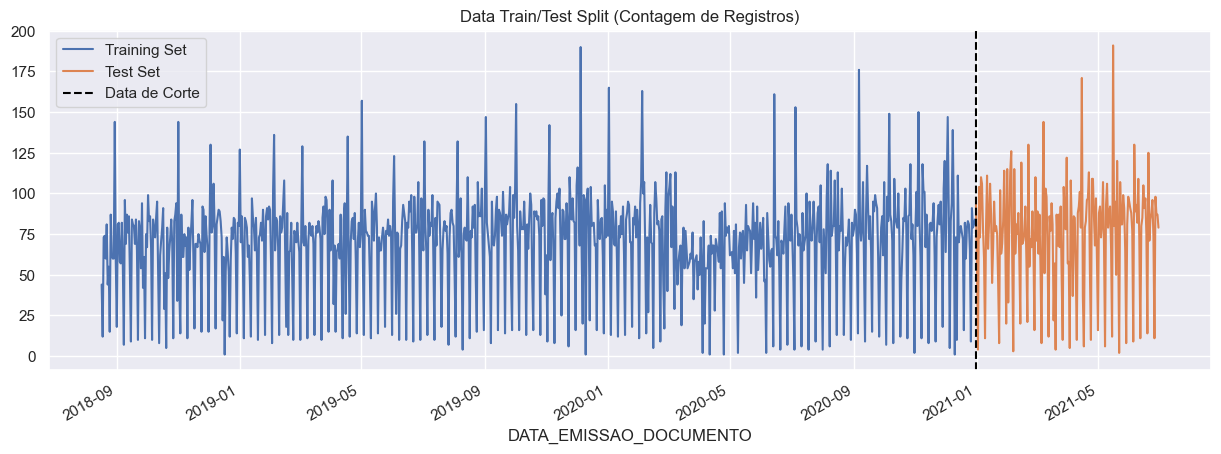

In [4408]:
train_counts = train.groupby('DATA_EMISSAO_DOCUMENTO').size()
test_counts = test.groupby('DATA_EMISSAO_DOCUMENTO').size()

fig, ax = plt.subplots(figsize=(15, 5))
train_counts.plot(ax=ax, label='Training Set', title='Data Train/Test Split (Contagem de Registros)')
test_counts.plot(ax=ax, label='Test Set')
ax.axvline(data_corte, color='black', ls='--')
ax.legend(['Training Set', 'Test Set', 'Data de Corte'])
plt.show()

In [4409]:
features = ['VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 
            'TEMPO_RELACIONAMENTO_MESES', 
            'MEDIA_CUM_DIAS_ATRASO', 'VARIANCIA_CUM_DIAS_ATRASO', 
            'TAXA_UTILIZACAO', 'NUMERO_INADIMPLENCIAS', 'TAXA_INADIMPLENCIA_SEGMENTO']

target = 'INADIMPLENTE'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [4410]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print("\nRelatório de Classificação:")
print(class_report)

print(f"train score: {rf_model.score(X_train, y_train)}")
print(f"teste score: {rf_model.score(X_test, y_test)}")

Acurácia: 0.9472

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     12779
           1       0.56      0.42      0.48       793

    accuracy                           0.95     13572
   macro avg       0.76      0.70      0.73     13572
weighted avg       0.94      0.95      0.94     13572

train score: 0.9999832951906854
teste score: 0.9471706454465075


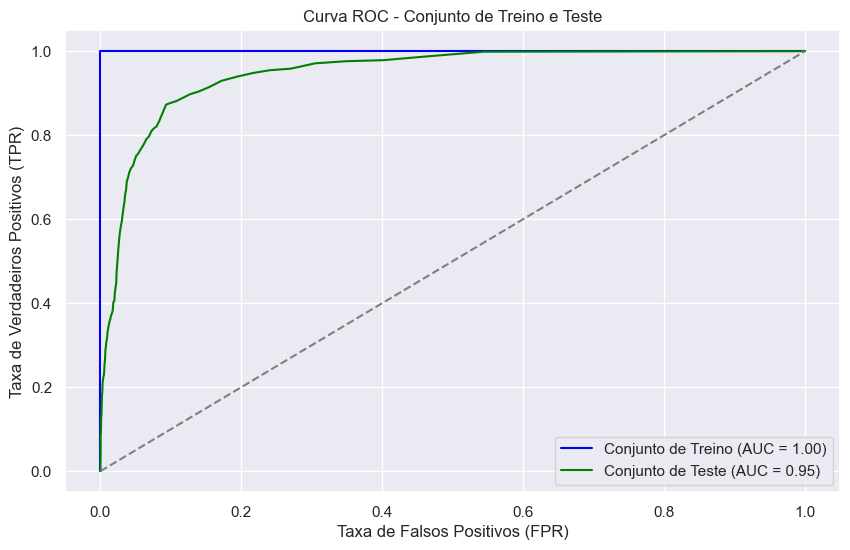

In [4333]:
# Previsões de probabilidade para o conjunto de treino e teste
y_train_proba = rf_model.predict_proba(X_train)[:, 1]
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

# Calcular a AUC
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# Calcular a curva ROC para o conjunto de treino e teste
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Conjunto de Treino (AUC = {train_auc:.2f})')
plt.plot(fpr_test, tpr_test, color='green', label=f'Conjunto de Teste (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Curva ROC - Conjunto de Treino e Teste')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()

O modelo está apresentando overfitting, o que indica que não está generalizando bem. Vou ajustar os hiperparâmetros para melhorar sua capacidade de generalização.

Importância das Features:
MEDIA_CUM_DIAS_ATRASO: 0.2109322644797053
VARIANCIA_CUM_DIAS_ATRASO: 0.16578202919153928
VALOR_A_PAGAR: 0.1309742390875213
NUMERO_INADIMPLENCIAS: 0.12531561247763193
TEMPO_RELACIONAMENTO_MESES: 0.08901797445218117
TAXA_UTILIZACAO: 0.08324062389239242
TAXA_INADIMPLENCIA_SEGMENTO: 0.07089890114243275
RENDA_MES_ANTERIOR: 0.05373254379711075
NO_FUNCIONARIOS: 0.05228393651683041
TAXA: 0.017821874962654614


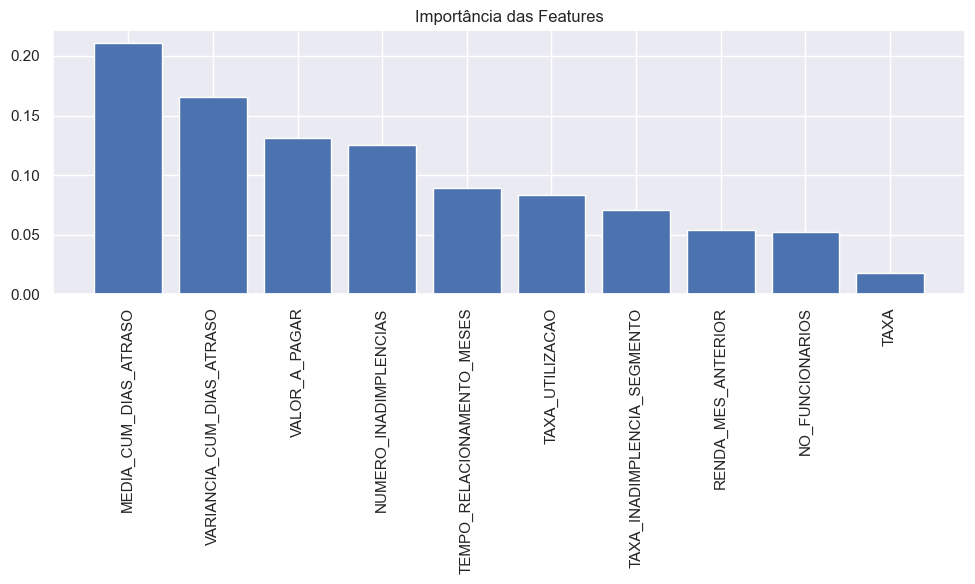

In [4249]:
importances = rf_model.feature_importances_
features = X_train.columns  # Certifique-se de que X_train seja um DataFrame para obter os nomes das colunas

# Ordenar as features por importância
indices = np.argsort(importances)[::-1]

# Exibir a importância das features em ordem decrescente
print("Importância das Features:")
for i in indices:
    print(f"{features[i]}: {importances[i]}")

# Plotar a importância das features
plt.figure(figsize=(10, 6))
plt.title("Importância das Features")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

## Tuning

### Randomize Search

In [3217]:
param_rf = {
    'n_estimators': np.arange(20, 200, step=20),                
    'max_depth': [None] + list(np.arange(2, 10, step=1)),             
    'min_samples_split': [10, 15, 20, 30, 40],                        
    'min_samples_leaf': [10, 15, 30, 50, 70, 100],              
    'max_features': ['sqrt','log2'],                     
    'criterion': ['gini', 'entropy'],                          
    'bootstrap': [True, False]                             
}

In [3218]:
rf = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 5})
tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(estimator=rf,
                                    param_distributions=param_rf,
                                    n_iter=50,
                                    cv=tscv,
                                    verbose=0,
                                    random_state=42,
                                    n_jobs=-1)

random_search.fit(X_train, y_train)

print("Melhores hiperparâmetros encontrados:", random_search.best_params_)

best_rf_model = random_search.best_estimator_

random_search.best_params_

Melhores hiperparâmetros encontrados: {'n_estimators': np.int64(140), 'min_samples_split': 40, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': np.int64(9), 'criterion': 'entropy', 'bootstrap': False}


{'n_estimators': np.int64(140),
 'min_samples_split': 40,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': np.int64(9),
 'criterion': 'entropy',
 'bootstrap': False}

In [3219]:
y_pred = best_rf_model.predict(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"F1-Score: {f1}")
print(f"Acurácia: {accuracy}") 
print(f"Relatório de Classificação:\n{report}")
print(f"train score: {best_rf_model.score(X_train, y_train)}")
print(f"test score: {best_rf_model.score(X_test, y_test)}")

F1-Score: 0.6507633587786259
Acurácia: 0.9401911920908571
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     11295
           1       0.59      0.72      0.65       944

    accuracy                           0.94     12239
   macro avg       0.78      0.84      0.81     12239
weighted avg       0.95      0.94      0.94     12239

train score: 0.951810575854631
test score: 0.9401911920908571


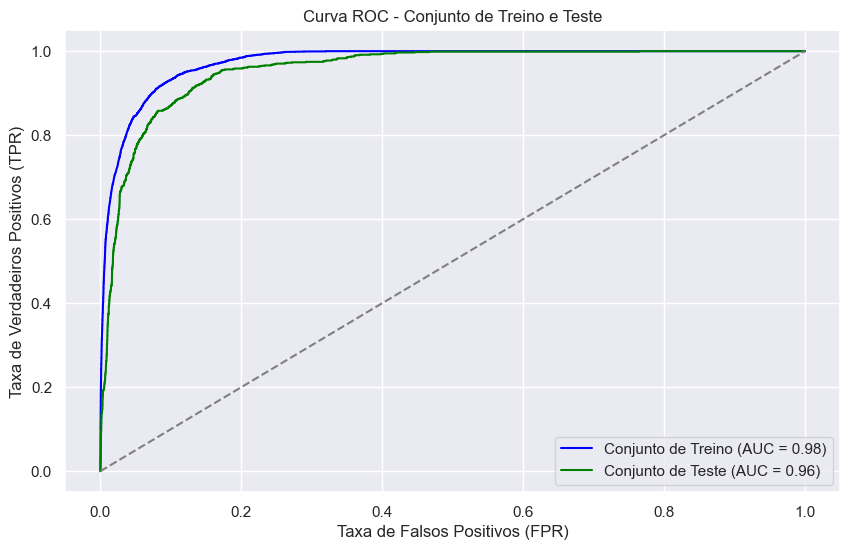

In [3223]:
y_train_proba = best_rf_model.predict_proba(X_train)[:, 1]
y_test_proba = best_rf_model.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Conjunto de Treino (AUC = {train_auc:.2f})')
plt.plot(fpr_test, tpr_test, color='green', label=f'Conjunto de Teste (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Curva ROC - Conjunto de Treino e Teste')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()

### Bayes Search

In [3200]:
param_rf = {
    'n_estimators': Integer(15, 300),
    'max_depth': Integer(5, 15),
    'min_samples_split': Integer(5, 25),
    'min_samples_leaf': Integer(5, 15),
    'max_features': Categorical(['sqrt', 'log2'])
}

In [3201]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=param_rf,
    n_iter=50, 
    cv=tscv,
    n_jobs=-1,
    verbose=0,
    random_state=42
)

bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
              estimator=RandomForestClassifier(class_weight='balanced',
                                               random_state=42),
              n_jobs=-1, random_state=42,
              search_spaces={'max_depth': Integer(low=5, high=15, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
                             'min_samples_leaf': Integer(low=5, high=15, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=5, high=25, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=15, high=300, prior='uniform', transform='normalize')})

In [3207]:
bayes_search.best_params_

OrderedDict([('max_depth', 15),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 5),
             ('min_samples_split', 5),
             ('n_estimators', 300)])

In [3208]:
best_rf_bayes_model = bayes_search.best_estimator_

In [3209]:
y_test_pred = best_rf_bayes_model.predict(X_test)

f1_test = f1_score(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
report_test = classification_report(y_test, y_test_pred)

print(f"F1-Score (teste): {f1_test}")
print(f"Acurácia (teste): {accuracy_test}")
print(f"Relatório de Classificação (teste):\n{report_test}")

print(f"train score: {best_rf_bayes_model.score(X_train, y_train)}")
print(f"test score: {best_rf_bayes_model.score(X_test, y_test)}")

F1-Score (teste): 0.6290322580645161
Acurácia (teste): 0.9436228450036768
Relatório de Classificação (teste):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11295
           1       0.64      0.62      0.63       944

    accuracy                           0.94     12239
   macro avg       0.80      0.80      0.80     12239
weighted avg       0.94      0.94      0.94     12239

train score: 0.9703248578338454
test score: 0.9436228450036768


# Stacking: XGBoost e RandomForest

In [3607]:
#redefinindo apenas para clareza
features = ['VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 
            'TEMPO_RELACIONAMENTO_MESES', 
            'MEDIA_CUM_DIAS_ATRASO', 'VARIANCIA_CUM_DIAS_ATRASO', 
            'TAXA_UTILIZACAO', 'NUMERO_INADIMPLENCIAS', 'TAXA_INADIMPLENCIA_SEGMENTO']

target = 'INADIMPLENTE'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [3608]:
param_dist_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=50,
    scoring='recall',
    n_jobs=-1,
    cv=tscv,
    random_state=42,
    verbose=1
)

random_search_rf.fit(X_train, y_train)

best_rf = random_search_rf.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [3609]:
param_dist_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [3, 5, 7, 9, 15],
    'subsample': [0.6, 0.8, 1.0]
}


xgb = xgb.XGBClassifier(random_state=42)

random_search_gb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=50,
    scoring='recall',
    n_jobs=-1,
    cv=tscv,
    random_state=42,
    verbose=1
)

random_search_gb.fit(X_train, y_train)

best_gb = random_search_gb.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [3611]:
param_dist_final_estimator = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'scale_pos_weight': [1, 2, 5]  
}

random_search_final_estimator = RandomizedSearchCV(
    estimator= best_gb,
    param_distributions=param_dist_final_estimator,
    n_iter=30,
    scoring='recall',
    n_jobs=-1,
    cv=tscv,
    random_state=42,
    verbose=1
)

random_search_final_estimator.fit(X_train, y_train)

best_final_estimator = random_search_final_estimator.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [3613]:
estimators = [
    ('rf', best_rf),
    ('gb', best_gb),

]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=best_final_estimator,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)

y_pred = stacking_clf.predict(X_test)

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

print(stacking_clf.score(X_train, y_train))
print(stacking_clf.score(X_test, y_test))


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     12779
           1       0.45      0.82      0.58       793

    accuracy                           0.93     13572
   macro avg       0.72      0.88      0.77     13572
weighted avg       0.96      0.93      0.94     13572

0.938726759434041
0.9303713527851459


## No tunning

In [3087]:
param_distributions = {
    'n_estimators': np.random.randint(50, 1001, size=10),       # Número de árvores (50 a 1000)
    'learning_rate': np.logspace(np.log10(0.0001), np.log10(1), base=10, num=10),    # Taxa de aprendizado (0.0001 a 1)
    'max_depth': np.random.randint(1, 11, size=10),             # Profundidade das árvores (1 a 10)
    'reg_alpha': np.logspace(np.log10(0.0001), np.log10(2), base=10, num=10),        # Regularização L1 (0.0001 a 2)
    'reg_lambda': np.logspace(np.log10(0.0001), np.log10(2), base=10, num=10)        # Regularização L2 (0.0001 a 2)
}


In [3090]:
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

default_xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=200)

default_xgb_model.fit(X_train_encoded, y_train)

y_pred_default = default_xgb_model.predict(X_test_encoded)

f1_default = f1_score(y_test, y_pred_default)
accuracy_default = accuracy_score(y_test, y_pred_default)
report_default = classification_report(y_test, y_pred_default)

print(f"F1-Score (default): {f1_default}")
print(f"Acurácia (default): {accuracy_default}")
print(f"Relatório de Classificação (default):\n{report_default}")

default_xgb_model.score(X_train, y_train)
default_xgb_model.score(X_test, y_test)

print(f"train score: {default_xgb_model.score(X_train, y_train)}")
print(f"test score: {default_xgb_model.score(X_test, y_test)}")

F1-Score (default): 0.5648379052369077
Acurácia (default): 0.9049499557431743
Relatório de Classificação (default):
              precision    recall  f1-score   support

           0       0.99      0.90      0.95     13712
           1       0.41      0.93      0.56       975

    accuracy                           0.90     14687
   macro avg       0.70      0.92      0.76     14687
weighted avg       0.96      0.90      0.92     14687

train score: 0.9255974671478178
test score: 0.9049499557431743


# Time Series Forecasting

In [3269]:
dados_ordenados['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(dados_ordenados['DATA_EMISSAO_DOCUMENTO'])


data_corte = pd.to_datetime('2020-12-31')  # Exemplo de data de corte
train = dados_ordenados[dados_ordenados['DATA_EMISSAO_DOCUMENTO'] < data_corte]

test = dados_ordenados[dados_ordenados['DATA_EMISSAO_DOCUMENTO'] >= data_corte]

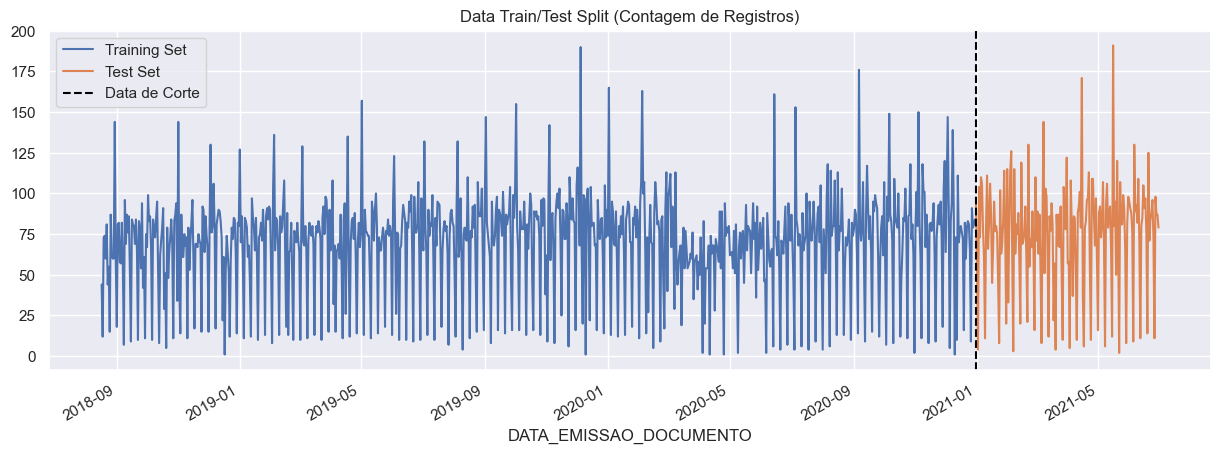

In [3272]:
train_counts = train.groupby('DATA_EMISSAO_DOCUMENTO').size()
test_counts = test.groupby('DATA_EMISSAO_DOCUMENTO').size()

# Criar o gráfico
fig, ax = plt.subplots(figsize=(15, 5))

# Plotar a contagem de registros no treino e no teste
train_counts.plot(ax=ax, label='Training Set', title='Data Train/Test Split (Contagem de Registros)')
test_counts.plot(ax=ax, label='Test Set')

# Adicionar uma linha vertical para marcar a data de corte
ax.axvline(data_corte, color='black', ls='--')

# Adicionar a legenda e exibir o gráfico
ax.legend(['Training Set', 'Test Set', 'Data de Corte'])
plt.show()

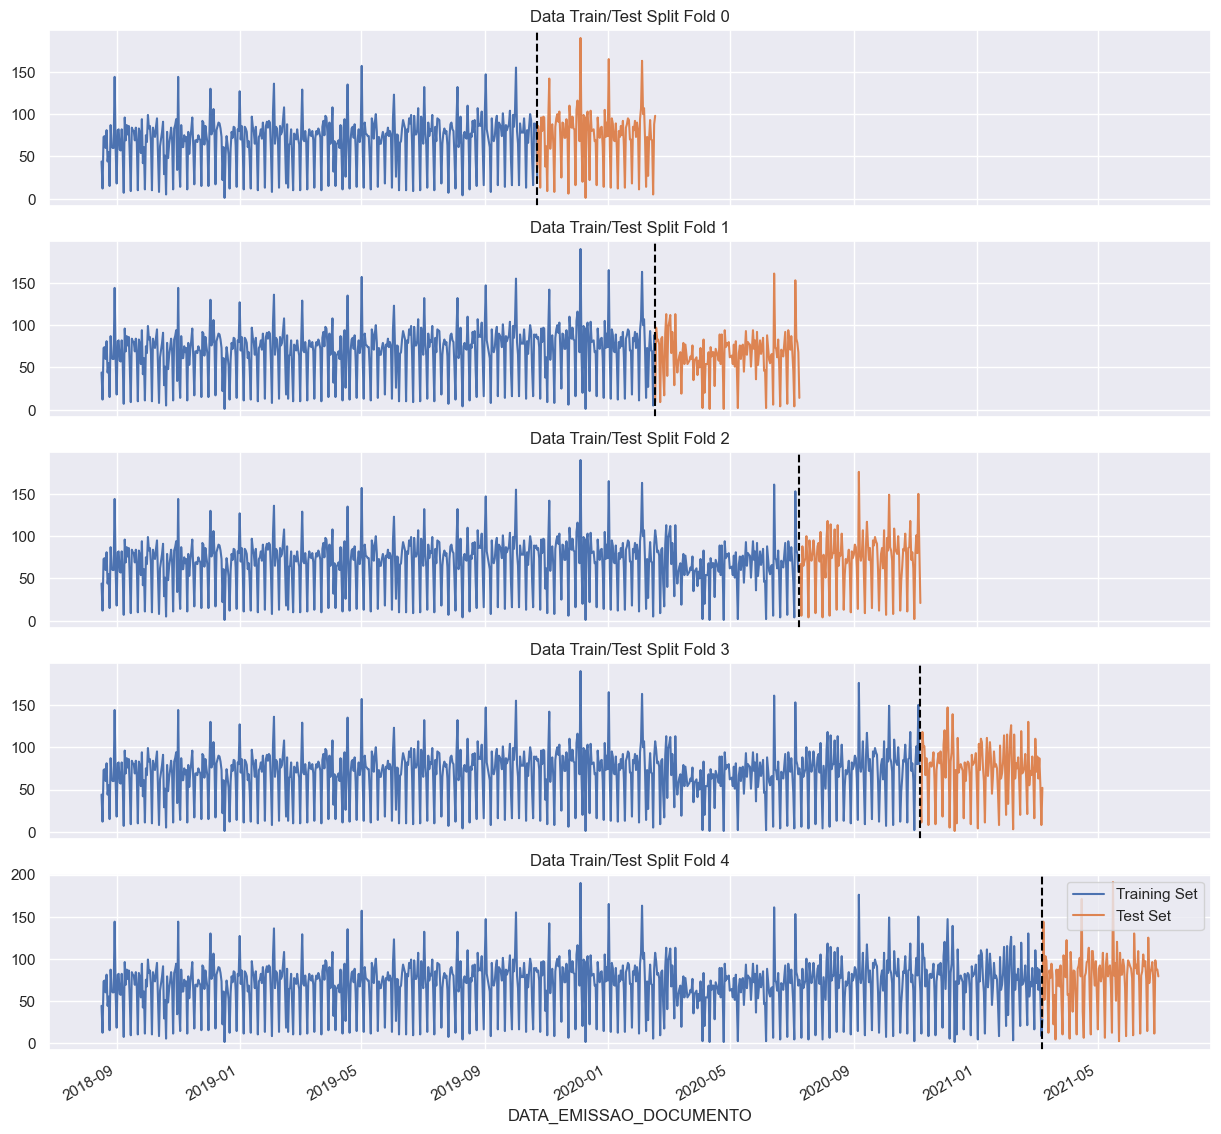

In [3273]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tscv.split(merged_final):
    train = merged_final.iloc[train_idx]
    test = merged_final.iloc[val_idx]

    train_counts = train.groupby('DATA_EMISSAO_DOCUMENTO').size()
    test_counts = test.groupby('DATA_EMISSAO_DOCUMENTO').size()

    train_counts.plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test_counts.plot(ax=axs[fold], label='Test Set')

    axs[fold].axvline(test['DATA_EMISSAO_DOCUMENTO'].min(), color='black', ls='--')

    fold += 1

plt.legend()
plt.show()


In [3274]:
FEATURES = ['VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 
            'TEMPO_RELACIONAMENTO_MESES', 
            'MEDIA_CUM_DIAS_ATRASO', 'VARIANCIA_CUM_DIAS_ATRASO', 
            'TAXA_UTILIZACAO', 'NUMERO_INADIMPLENCIAS', 'TAXA_INADIMPLENCIA_SEGMENTO']

TARGET = 'INADIMPLENTE'

In [3275]:
merged_final = merged_final.set_index('DATA_EMISSAO_DOCUMENTO').sort_index()

merged_final

,ID_CLIENTE,SAFRA_REF,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DATA_CADASTRO,DDD,...,TEMPO_RELACIONAMENTO_MESES,DIAS_ATRASO_PAGAMENTO,CUM_SUM_ATRASO,CUM_SUM_ATRASO_QUADRADO,CUM_COUNT,MEDIA_CUM_DIAS_ATRASO,VARIANCIA_CUM_DIAS_ATRASO,TAXA_UTILIZACAO,NUMERO_INADIMPLENCIAS,TAXA_INADIMPLENCIA_SEGMENTO
DATA_EMISSAO_DOCUMENTO,,,,,,,,,,,,,,,,,,,,,
2018-08-17,8784237149961904,2018-08,2018-09-04,2018-09-04,100616.10,5.99,300502.0,107.0,2011-02-14,11,...,91.366667,0,0,0,1,0.000000,0.00000,0.334827,0.0,0.000000
2018-08-17,4334472256949955221,2018-08,2018-09-03,2018-09-03,38391.54,5.99,354607.0,109.0,2012-03-11,48,...,78.333333,0,0,0,1,0.000000,0.00000,0.108265,0.0,0.000000
2018-08-17,4095739077267179172,2018-08,2018-09-03,2018-09-03,91187.75,6.99,292798.0,122.0,2011-02-14,21,...,91.366667,0,0,0,1,0.000000,0.00000,0.311436,0.0,0.000000
2018-08-17,4052557282157719526,2018-08,2018-09-03,2018-09-03,29891.85,4.99,286491.0,112.0,2009-08-30,19,...,109.133333,0,0,0,1,0.000000,0.00000,0.104338,0.0,0.000000
2018-08-17,3668905663669864663,2018-08,2018-09-03,2018-09-03,21476.35,8.99,331138.0,137.0,2011-02-14,44,...,91.366667,0,0,0,1,0.000000,0.00000,0.064856,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30,1115703227712697214,2021-06,2021-07-30,2021-07-30,100851.89,5.99,318262.0,95.0,2011-02-14,82,...,126.300000,0,1368,331772,130,10.523077,2441.35716,0.316883,9.0,0.044715
2021-06-30,5220206408301580591,2021-06,2021-08-16,2021-08-16,42239.00,5.99,235315.0,87.0,2021-04-08,19,...,2.766667,0,0,0,2,0.000000,0.00000,0.179500,0.0,0.069445
2021-06-30,5200455618694210402,2021-06,2021-07-19,2021-07-19,197916.84,6.99,366474.0,94.0,2015-05-10,85,...,74.766667,0,0,0,12,0.000000,0.00000,0.540057,0.0,0.044713


In [3281]:
preds = []
scores = []
train_auc_scores = []
test_auc_scores = []

fold = 0
for train_idx, val_idx in tscv.split(merged_final):
    train = merged_final.iloc[train_idx]
    test = merged_final.iloc[val_idx]

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    clf = xgb.XGBClassifier(
        base_score=0.5, 
        booster='gbtree',    
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='binary:logistic',  
        max_depth=3,
        learning_rate=0.01,
        random_state=42,
        eval_metric='logloss' 
    )

    clf.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_train_pred = clf.predict(X_train)
    y_train_pred_proba = clf.predict_proba(X_train)[:, 1]
    
    y_test_pred = clf.predict(X_test)
    y_test_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probabilidades para AUC

    preds.append(y_test_pred)

    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    test_auc = roc_auc_score(y_test, y_test_pred_proba)
    
    train_auc_scores.append(train_auc)
    test_auc_scores.append(test_auc)
    
    fold += 1
    print(f'Fold {fold}: Train AUC = {train_auc:.4f}, Test AUC = {test_auc:.4f}')

    print(f"\nClassification Report - Fold {fold}:")
    print(classification_report(y_test, y_test_pred))

print(f'\nMédia AUC dos folds (Treino): {np.mean(train_auc_scores):.4f}')
print(f'Média AUC dos folds (Teste): {np.mean(test_auc_scores):.4f}')

[0]	validation_0-logloss:0.68454	validation_1-logloss:0.68511
[100]	validation_0-logloss:0.26659	validation_1-logloss:0.29986
[200]	validation_0-logloss:0.15317	validation_1-logloss:0.20202
[300]	validation_0-logloss:0.11437	validation_1-logloss:0.17210
[400]	validation_0-logloss:0.09978	validation_1-logloss:0.16282
[500]	validation_0-logloss:0.09316	validation_1-logloss:0.15983
[600]	validation_0-logloss:0.08921	validation_1-logloss:0.15880
[700]	validation_0-logloss:0.08640	validation_1-logloss:0.15832
[800]	validation_0-logloss:0.08399	validation_1-logloss:0.15732
[900]	validation_0-logloss:0.08168	validation_1-logloss:0.15652
[999]	validation_0-logloss:0.07989	validation_1-logloss:0.15600
Fold 1: Train AUC = 0.9825, Test AUC = 0.9489

Classification Report - Fold 1:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      7988
           1       0.65      0.43      0.52       772

    accuracy                           0.93      8760
 

Infelizmente, não tive tempo de concluir a análise. Vou realizar as predições no conjunto de teste para poder enviar o que já foi feito até o momento.

# base_pagamentos_teste




In [4411]:
base_pagamentos_teste

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99
3,274692171162531764,2021-07,2021-07-16,2021-08-30,62250.00,5.99
4,465309249432033993,2021-07,2021-07-05,2021-07-30,26593.95,6.99
...,...,...,...,...,...,...
12270,705648002974742140,2021-11,2021-11-25,2021-12-13,47010.00,6.99
12271,4993499380140734678,2021-11,2021-11-25,2021-12-13,122875.35,8.99
12272,4614484019183480654,2021-11,2021-11-26,2028-09-30,302200.00,5.99
12273,1299146298565441811,2021-11,2021-11-26,2021-12-13,143791.85,5.99


In [4412]:
len(base_pagamentos_teste['ID_CLIENTE'].unique())

976

Temos 976 ID_CLIENTE unicos na base de dados para prever a inadimplencia, porém, eu preciso de dados históricos desses clientes.

In [4413]:
base_pagamentos_teste_filtrada = base_pagamentos_teste[base_pagamentos_teste['ID_CLIENTE'].isin(clientes_comuns)]

In [4414]:
len(base_pagamentos_teste_filtrada['ID_CLIENTE'].unique())

888

Mantive apenas os ID_CLIENTE na qual havíamos dados nas outras bases, para conseguirmos os dados históricos.

## Merge

Como algumas features não estão presentes, irei buscar na merged_final. 

- NO_FUNCIONARIOS será o último valor registrado para o mesmo ID_CLIENTE 
- RENDA_MES_ANTERIOR será a renda das últimas 10 transações do mesmo ID_CLIENTE (se menor que 10, é a média do total)
- TEMPO_RELACIONAMENTO_MESES continua com a mesma definição.
- MEDIA_CUM_DIAS_ATRASO será o último valor de dias acumulados de atraso de pagamento.
- VARIANCIA_CUM_DIAS_ATRASO será o último valor registrado
- TAXA_UTILIZACAO seguirá com a mesma definição (RENDA/VALOR_A_PAGAR)

In [4415]:
#NO_FUNCIONARIOS
ultimo_valor_no_funcionarios = merged_final.groupby('ID_CLIENTE')['NO_FUNCIONARIOS'].last().reset_index()
base_pagamentos_teste = base_pagamentos_teste.merge(ultimo_valor_no_funcionarios, on='ID_CLIENTE', how='left')
base_pagamentos_teste

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,NO_FUNCIONARIOS
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99,153.0
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99,110.0
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99,110.0
3,274692171162531764,2021-07,2021-07-16,2021-08-30,62250.00,5.99,110.0
4,465309249432033993,2021-07,2021-07-05,2021-07-30,26593.95,6.99,113.0
...,...,...,...,...,...,...,...
12270,705648002974742140,2021-11,2021-11-25,2021-12-13,47010.00,6.99,103.0
12271,4993499380140734678,2021-11,2021-11-25,2021-12-13,122875.35,8.99,146.0
12272,4614484019183480654,2021-11,2021-11-26,2028-09-30,302200.00,5.99,121.0
12273,1299146298565441811,2021-11,2021-11-26,2021-12-13,143791.85,5.99,132.0


In [4416]:
def calcular_media_ultimas_10_rendas(grupo):
    # Se o grupo tiver menos de 10 registros, calcular a média do total
    if len(grupo) < 10:
        return grupo['RENDA_MES_ANTERIOR'].mean()
    else:
        # Caso contrário, calcular a média das últimas 10 rendas
        return grupo['RENDA_MES_ANTERIOR'].tail(10).mean()

# Aplicar a função para cada cliente
media_renda = merged_final.groupby('ID_CLIENTE').apply(calcular_media_ultimas_10_rendas).reset_index()
media_renda.columns = ['ID_CLIENTE', 'RENDA_MES_ANTERIOR']

# Passo 3: Fazer o merge com base_pagamentos_teste
base_pagamentos_teste = base_pagamentos_teste.merge(media_renda, on='ID_CLIENTE', how='left')
base_pagamentos_teste

/var/folders/2j/4bp3mpqn673cqywvjyhff8_w0000gq/T/ipykernel_10242/2347400626.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  media_renda = merged_final.groupby('ID_CLIENTE').apply(calcular_media_ultimas_10_rendas).reset_index()


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,NO_FUNCIONARIOS,RENDA_MES_ANTERIOR
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99,153.0,249263.8
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99,110.0,342990.8
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99,110.0,342990.8
3,274692171162531764,2021-07,2021-07-16,2021-08-30,62250.00,5.99,110.0,342990.8
4,465309249432033993,2021-07,2021-07-05,2021-07-30,26593.95,6.99,113.0,188966.8
...,...,...,...,...,...,...,...,...
12270,705648002974742140,2021-11,2021-11-25,2021-12-13,47010.00,6.99,103.0,332644.0
12271,4993499380140734678,2021-11,2021-11-25,2021-12-13,122875.35,8.99,146.0,336489.1
12272,4614484019183480654,2021-11,2021-11-26,2028-09-30,302200.00,5.99,121.0,316617.1
12273,1299146298565441811,2021-11,2021-11-26,2021-12-13,143791.85,5.99,132.0,248514.0


In [4417]:
data_cadastro = merged_final[['ID_CLIENTE', 'DATA_CADASTRO']].drop_duplicates()

base_pagamentos_teste = base_pagamentos_teste.merge(data_cadastro, on='ID_CLIENTE', how='left')

In [4418]:
base_pagamentos_teste['DATA_CADASTRO'] = pd.to_datetime(base_pagamentos_teste['DATA_CADASTRO'])
base_pagamentos_teste['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(base_pagamentos_teste['DATA_EMISSAO_DOCUMENTO'])

base_pagamentos_teste['TEMPO_RELACIONAMENTO_MESES'] = (base_pagamentos_teste['DATA_EMISSAO_DOCUMENTO'] - 
                                                      base_pagamentos_teste['DATA_CADASTRO']).dt.total_seconds() / (30 * 24 * 60 * 60)

In [4419]:
ultimo_valor_media_atraso = merged_final.groupby('ID_CLIENTE')['MEDIA_CUM_DIAS_ATRASO'].last().reset_index()

base_pagamentos_teste = base_pagamentos_teste.merge(ultimo_valor_media_atraso, on='ID_CLIENTE', how='left')


In [4420]:
ultimo_valor_variancia_atraso = merged_final.groupby('ID_CLIENTE')['VARIANCIA_CUM_DIAS_ATRASO'].last().reset_index()
ultimo_valor_taxa_utilizacao = merged_final.groupby('ID_CLIENTE')['TAXA_UTILIZACAO'].last().reset_index()

# Passo 2: Fazer o merge com base_pagamentos_teste
base_pagamentos_teste = base_pagamentos_teste.merge(ultimo_valor_variancia_atraso, on='ID_CLIENTE', how='left')
base_pagamentos_teste = base_pagamentos_teste.merge(ultimo_valor_taxa_utilizacao, on='ID_CLIENTE', how='left')

In [4421]:
base_pagamentos_teste.columns

Index(['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_VENCIMENTO',
       'VALOR_A_PAGAR', 'TAXA', 'NO_FUNCIONARIOS', 'RENDA_MES_ANTERIOR',
       'DATA_CADASTRO', 'TEMPO_RELACIONAMENTO_MESES', 'MEDIA_CUM_DIAS_ATRASO',
       'VARIANCIA_CUM_DIAS_ATRASO', 'TAXA_UTILIZACAO'],
      dtype='object')

In [4422]:
ultimo_segmento = merged_final.groupby('ID_CLIENTE')['SEGMENTO_INDUSTRIAL'].last().dropna().reset_index()
base_pagamentos_teste = base_pagamentos_teste.merge(ultimo_segmento, on='ID_CLIENTE', how='left')


In [4423]:
# Passo 3: Obter o último valor de NUMERO_INADIMPLENCIAS para cada cliente
ultimo_numero_inadimplencias = merged_final.groupby('ID_CLIENTE')['NUMERO_INADIMPLENCIAS'].last().dropna().reset_index()

base_pagamentos_teste = base_pagamentos_teste.merge(ultimo_numero_inadimplencias, on='ID_CLIENTE', how='left')
ultimo_valor_taxa_inadimplencia_segmento = merged_final.groupby('SEGMENTO_INDUSTRIAL')['TAXA_INADIMPLENCIA_SEGMENTO'].last().dropna().reset_index()

base_pagamentos_teste = base_pagamentos_teste.merge(ultimo_valor_taxa_inadimplencia_segmento, on='SEGMENTO_INDUSTRIAL', how='left')


In [4424]:
base_pagamentos_teste.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,NO_FUNCIONARIOS,RENDA_MES_ANTERIOR,DATA_CADASTRO,TEMPO_RELACIONAMENTO_MESES,MEDIA_CUM_DIAS_ATRASO,VARIANCIA_CUM_DIAS_ATRASO,TAXA_UTILIZACAO,SEGMENTO_INDUSTRIAL,NUMERO_INADIMPLENCIAS,TAXA_INADIMPLENCIA_SEGMENTO
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99,153.0,249263.8,2014-03-30,88.766667,0.148148,0.237311,0.096412,Serviços,0.0,0.082638
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99,110.0,342990.8,2005-08-03,193.933333,1.269565,91.996900,0.101980,Serviços,6.0,0.082638
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99,110.0,342990.8,2005-08-03,194.033333,1.269565,91.996900,0.101980,Serviços,6.0,0.082638
3,274692171162531764,2021-07,2021-07-16,2021-08-30,62250.00,5.99,110.0,342990.8,2005-08-03,194.200000,1.269565,91.996900,0.101980,Serviços,6.0,0.082638
4,465309249432033993,2021-07,2021-07-05,2021-07-30,26593.95,6.99,113.0,188966.8,2014-07-23,84.633333,0.028777,0.027949,0.467993,Comércio,0.0,0.044713


# Predict

In [4425]:
features = ['VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 
            'TEMPO_RELACIONAMENTO_MESES', 
            'MEDIA_CUM_DIAS_ATRASO', 'VARIANCIA_CUM_DIAS_ATRASO', 
            'TAXA_UTILIZACAO', 'NUMERO_INADIMPLENCIAS', 'TAXA_INADIMPLENCIA_SEGMENTO']

In [4426]:
base_pagamentos_teste

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,NO_FUNCIONARIOS,RENDA_MES_ANTERIOR,DATA_CADASTRO,TEMPO_RELACIONAMENTO_MESES,MEDIA_CUM_DIAS_ATRASO,VARIANCIA_CUM_DIAS_ATRASO,TAXA_UTILIZACAO,SEGMENTO_INDUSTRIAL,NUMERO_INADIMPLENCIAS,TAXA_INADIMPLENCIA_SEGMENTO
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99,153.0,249263.8,2014-03-30,88.766667,0.148148,0.237311,0.096412,Serviços,0.0,0.082638
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99,110.0,342990.8,2005-08-03,193.933333,1.269565,91.996900,0.101980,Serviços,6.0,0.082638
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99,110.0,342990.8,2005-08-03,194.033333,1.269565,91.996900,0.101980,Serviços,6.0,0.082638
3,274692171162531764,2021-07,2021-07-16,2021-08-30,62250.00,5.99,110.0,342990.8,2005-08-03,194.200000,1.269565,91.996900,0.101980,Serviços,6.0,0.082638
4,465309249432033993,2021-07,2021-07-05,2021-07-30,26593.95,6.99,113.0,188966.8,2014-07-23,84.633333,0.028777,0.027949,0.467993,Comércio,0.0,0.044713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12270,705648002974742140,2021-11,2021-11-25,2021-12-13,47010.00,6.99,103.0,332644.0,2020-01-26,22.300000,1.000000,5.636364,0.734288,Indústria,1.0,0.069445
12271,4993499380140734678,2021-11,2021-11-25,2021-12-13,122875.35,8.99,146.0,336489.1,2015-11-24,73.100000,0.571429,10.634508,0.171714,Serviços,2.0,0.082638
12272,4614484019183480654,2021-11,2021-11-26,2028-09-30,302200.00,5.99,121.0,316617.1,2011-02-14,131.266667,0.090909,0.537190,0.217052,Indústria,1.0,0.069445
12273,1299146298565441811,2021-11,2021-11-26,2021-12-13,143791.85,5.99,132.0,248514.0,2000-08-15,259.100000,0.513889,3.694252,0.312294,Serviços,4.0,0.082638


In [4427]:
X_teste = base_pagamentos_teste[features]

In [4430]:
X_train

,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,TEMPO_RELACIONAMENTO_MESES,MEDIA_CUM_DIAS_ATRASO,VARIANCIA_CUM_DIAS_ATRASO,TAXA_UTILIZACAO,NUMERO_INADIMPLENCIAS,TAXA_INADIMPLENCIA_SEGMENTO
166,1.270381,-0.443208,0.039393,-0.592142,-0.378849,-0.257908,-0.102770,-0.016208,-0.273617,-3.327836
90,0.778070,0.111633,-0.605293,-0.144467,1.314997,-0.257908,-0.102770,0.014213,-0.273617,-3.327836
52,-0.305042,0.111633,-0.215884,-0.927899,-1.526336,-0.257908,-0.102770,-0.055594,-0.273617,-3.327836
84,0.706366,0.111633,0.700070,-0.592142,1.314997,-0.257908,-0.102770,-0.048226,-0.273617,-3.327836
273,0.090425,0.111633,-0.148968,-0.983858,1.314997,-0.257908,-0.102770,-0.044249,-0.273617,-3.327836
...,...,...,...,...,...,...,...,...,...,...
63982,2.441839,-0.443208,-0.302266,0.750885,1.697492,-0.252055,-0.102743,0.048477,-0.273617,-0.988222
62255,-0.145051,0.111633,-0.871945,0.135331,0.003646,-0.250182,-0.102077,-0.007341,-0.235756,1.172731
62254,-0.065719,0.111633,-0.871945,0.135331,0.003646,-0.250168,-0.102076,-0.001054,-0.235756,1.172907
63275,-0.276175,-0.443208,-0.101377,-0.312345,-0.547571,-0.239337,-0.102656,-0.057140,-0.273617,0.239134


In [4350]:
X_teste

,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,TEMPO_RELACIONAMENTO_MESES,MEDIA_CUM_DIAS_ATRASO,VARIANCIA_CUM_DIAS_ATRASO,TAXA_UTILIZACAO,NUMERO_INADIMPLENCIAS,TAXA_INADIMPLENCIA_SEGMENTO
0,11204.75,4.99,249263.8,153.0,88.766667,0.148148,0.237311,0.096412,0.0,0.082638
1,60718.50,5.99,342990.8,110.0,193.933333,1.269565,91.996900,0.101980,6.0,0.082638
2,60718.50,5.99,342990.8,110.0,194.033333,1.269565,91.996900,0.101980,6.0,0.082638
3,62250.00,5.99,342990.8,110.0,194.200000,1.269565,91.996900,0.101980,6.0,0.082638
4,26593.95,6.99,188966.8,113.0,84.633333,0.028777,0.027949,0.467993,0.0,0.044713
...,...,...,...,...,...,...,...,...,...,...
12270,47010.00,6.99,332644.0,103.0,22.300000,1.000000,5.636364,0.734288,1.0,0.069445
12271,122875.35,8.99,336489.1,146.0,73.100000,0.571429,10.634508,0.171714,2.0,0.082638
12272,302200.00,5.99,316617.1,121.0,131.266667,0.090909,0.537190,0.217052,1.0,0.069445
12273,143791.85,5.99,248514.0,132.0,259.100000,0.513889,3.694252,0.312294,4.0,0.082638


In [4428]:
numerical_columns = ['VALOR_A_PAGAR', 'TAXA', 'RENDA', 'NO_FUNCIONARIOS', 
                     'TEMPO_RELACIONAMENTO_MESES', 'MEDIA_CUM_DIAS_ATRASO', 
                     'VARIANCIA_CUM_DIAS_ATRASO', 'TAXA_UTILIZACAO', 
                     'NUMERO_INADIMPLENCIAS', 'TAXA_INADIMPLENCIA_SEGMENTO', 'RENDA_MES_ANTERIOR']

numerical_columns = [col for col in numerical_columns if col in base_pagamentos_teste.columns]

scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(base_pagamentos_teste[numerical_columns])

# Converter para DataFrame
numerical_scaled_df = pd.DataFrame(numerical_scaled, columns=numerical_columns)

In [4434]:
numerical_scaled_df.columns

Index(['VALOR_A_PAGAR', 'TAXA', 'NO_FUNCIONARIOS',
       'TEMPO_RELACIONAMENTO_MESES', 'MEDIA_CUM_DIAS_ATRASO',
       'VARIANCIA_CUM_DIAS_ATRASO', 'TAXA_UTILIZACAO', 'NUMERO_INADIMPLENCIAS',
       'TAXA_INADIMPLENCIA_SEGMENTO', 'RENDA_MES_ANTERIOR'],
      dtype='object')

In [4435]:
numerical_scaled_df = numerical_scaled_df[X_train.columns]
numerical_scaled_df

,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,TEMPO_RELACIONAMENTO_MESES,MEDIA_CUM_DIAS_ATRASO,VARIANCIA_CUM_DIAS_ATRASO,TAXA_UTILIZACAO,NUMERO_INADIMPLENCIAS,TAXA_INADIMPLENCIA_SEGMENTO
0,-0.978924,-0.990189,-0.333517,1.514256,-0.550083,-0.351113,-0.164953,-0.220682,-0.329718,1.040212
1,-0.092727,-0.445312,0.248476,-0.898606,0.800272,0.124624,0.063755,-0.217718,-0.075994,1.040212
2,-0.092727,-0.445312,0.248476,-0.898606,0.801556,0.124624,0.063755,-0.217718,-0.075994,1.040212
3,-0.065316,-0.445312,0.248476,-0.898606,0.803696,0.124624,0.063755,-0.217718,-0.075994,1.040212
4,-0.703488,0.099565,-0.707928,-0.730267,-0.603155,-0.401753,-0.165475,-0.022851,-0.329718,-1.224241
...,...,...,...,...,...,...,...,...,...,...
12270,-0.338082,0.099565,0.184228,-1.291398,-1.403524,0.010267,-0.151496,0.118925,-0.287431,0.252505
12271,1.019755,1.189319,0.208104,1.121464,-0.751245,-0.171545,-0.139038,-0.180591,-0.245144,1.040212
12272,4.229306,-0.445312,0.084710,-0.281362,-0.004377,-0.375395,-0.164206,-0.156453,-0.287431,0.252505
12273,1.394119,-0.445312,-0.338173,0.335881,1.637021,-0.195955,-0.156337,-0.105746,-0.160569,1.040212


In [4436]:
probabilidades_inadimplencia = stacking_clf.predict_proba(numerical_scaled_df)[:, 1]  # Pegando a probabilidade da classe 1 (inadimplente)

In [4447]:
base_pagamentos_teste['INADIMPLENTE'] = probabilidades_inadimplencia

In [4448]:
base_pagamentos_teste

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,NO_FUNCIONARIOS,RENDA_MES_ANTERIOR,DATA_CADASTRO,TEMPO_RELACIONAMENTO_MESES,MEDIA_CUM_DIAS_ATRASO,VARIANCIA_CUM_DIAS_ATRASO,TAXA_UTILIZACAO,SEGMENTO_INDUSTRIAL,NUMERO_INADIMPLENCIAS,TAXA_INADIMPLENCIA_SEGMENTO,INADIMPLENTE
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99,153.0,249263.8,2014-03-30,88.766667,0.148148,0.237311,0.096412,Serviços,0.0,0.082638,0.046419
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99,110.0,342990.8,2005-08-03,193.933333,1.269565,91.996900,0.101980,Serviços,6.0,0.082638,0.365678
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99,110.0,342990.8,2005-08-03,194.033333,1.269565,91.996900,0.101980,Serviços,6.0,0.082638,0.365678
3,274692171162531764,2021-07,2021-07-16,2021-08-30,62250.00,5.99,110.0,342990.8,2005-08-03,194.200000,1.269565,91.996900,0.101980,Serviços,6.0,0.082638,0.365678
4,465309249432033993,2021-07,2021-07-05,2021-07-30,26593.95,6.99,113.0,188966.8,2014-07-23,84.633333,0.028777,0.027949,0.467993,Comércio,0.0,0.044713,0.040181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12270,705648002974742140,2021-11,2021-11-25,2021-12-13,47010.00,6.99,103.0,332644.0,2020-01-26,22.300000,1.000000,5.636364,0.734288,Indústria,1.0,0.069445,0.119718
12271,4993499380140734678,2021-11,2021-11-25,2021-12-13,122875.35,8.99,146.0,336489.1,2015-11-24,73.100000,0.571429,10.634508,0.171714,Serviços,2.0,0.082638,0.067702
12272,4614484019183480654,2021-11,2021-11-26,2028-09-30,302200.00,5.99,121.0,316617.1,2011-02-14,131.266667,0.090909,0.537190,0.217052,Indústria,1.0,0.069445,0.040749
12273,1299146298565441811,2021-11,2021-11-26,2021-12-13,143791.85,5.99,132.0,248514.0,2000-08-15,259.100000,0.513889,3.694252,0.312294,Serviços,4.0,0.082638,0.095138


In [4449]:
base_final = base_pagamentos_teste[['ID_CLIENTE', 'SAFRA_REF', 'INADIMPLENTE']]

In [4450]:
base_final.to_csv("base_final.csv")